In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta, time
import glob
import learning_lidar.utils.global_settings as gs
import pandas as pd
import learning_lidar.preprocessing.preprocessing as prep
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from IPython.display import display
from learning_lidar.generation.daily_signals_generations_utils import calc_r2_ds,get_daily_bg,\
    custom_plot_xr
import learning_lidar.generation.generation_utils as gen_utils
from tqdm import tqdm
gs.set_visualization_settings()

In [14]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       nbins=100, log_scale=False,
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png'):
    date_datetime = prep.get_daily_ds_date ( dataset )
    ds_profile = dataset.get(profile_type)
    df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size %',
                                     'positive %', 'negative %','zeros %',
                                     'mean' , 'std'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),sharey=True)
    ax = axes
    th = gs.eps
    wavelengths = dataset.Wavelength.values.tolist()
    for ind,(wavelength) in enumerate(wavelengths):
        sub_ds = ds_profile.sel(Wavelength = wavelength)
        valid_vals = sub_ds.where(sub_ds != np.nan ).values
        valid_size = valid_vals.size
        orig_size = sub_ds.values.size

        # positive values histogram
        pos_ds = sub_ds.where(sub_ds > th).where(sub_ds != np.nan)#.values
        pos_vals = pos_ds.values[~np.isnan(pos_ds.values)]
        pos_size = pos_vals.size

        hist, bins =np.histogram(pos_vals , bins=nbins)
        min_bin = bins[0] if bins[0]>0 else bins[0]+gs.eps
        max_bin = bins[-1]
        logbins = np.logspace(np.log10(min_bin),np.log10(max_bin),len(bins))
        ax.hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
                   alpha=0.4)
        #sub_ds.where(sub_ds>gs.eps).plot.hist(
        #    alpha=0.4,bins=nbins, label = f"$\lambda={wavelength}$",ax=ax)

        if log_scale:
            ax.set_xscale('symlog')

        #negative values histogram
        neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
        neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
        neg_size = neg_vals.size


        # Zero values histogram
        zero_ds= sub_ds.where(sub_ds >= -th).where(sub_ds <=th).where(sub_ds != np.nan )
        zero_vals= zero_ds.values[~np.isnan(zero_ds.values)]
        zero_size = zero_vals.size

        df_stats.loc[ind] = [wavelength,
                            100.0*valid_size/orig_size,
                            100.0*pos_size/orig_size ,
                            100.0*neg_size/orig_size ,
                            100.0*zero_size/orig_size,
                            sub_ds.mean().values,
                            sub_ds.std().values]
        # TODO : take care of representation after the digit values

    ax.legend()
    min_val, max_val = float(ds_profile.min().values),float(ds_profile.max().values)
    ax.set_xlim([min_val,max_val+0.1*(max_val-min_val)])
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major')
    xlabels = f"{ds_profile.long_name} [{ds_profile.units}]"
    ax.set_xlabel(xlabels, horizontalalignment='center')
    print(date_datetime)
    stitle = f"Histogram of {ds_profile.info.lower()} " \
             f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
    fig.suptitle(stitle)
    plt.tight_layout()
    plt.show()

    if SAVE_FIG :
        fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
                f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
        if not os.path.exists ( dst_folder ) :
            try :
                os.makedirs ( dst_folder , exist_ok = True )
                print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
            except Exception :
                raise OSError ( f"Failed to create folder: {dst_folder}" )
        fpath = os.path.join ( dst_folder , fname )
        fig.savefig(fpath,bbox_inches='tight', format = format_fig)
        print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
    return fig,axes,df_stats

In [3]:
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()
dates = [datetime(2017,9,2), datetime(2017,9,15),datetime(2017,10,2),datetime(2017,10,15)]
dt_day = dates[0]
r2_da = calc_r2_ds(station, dt_day)

# 1. Background signal

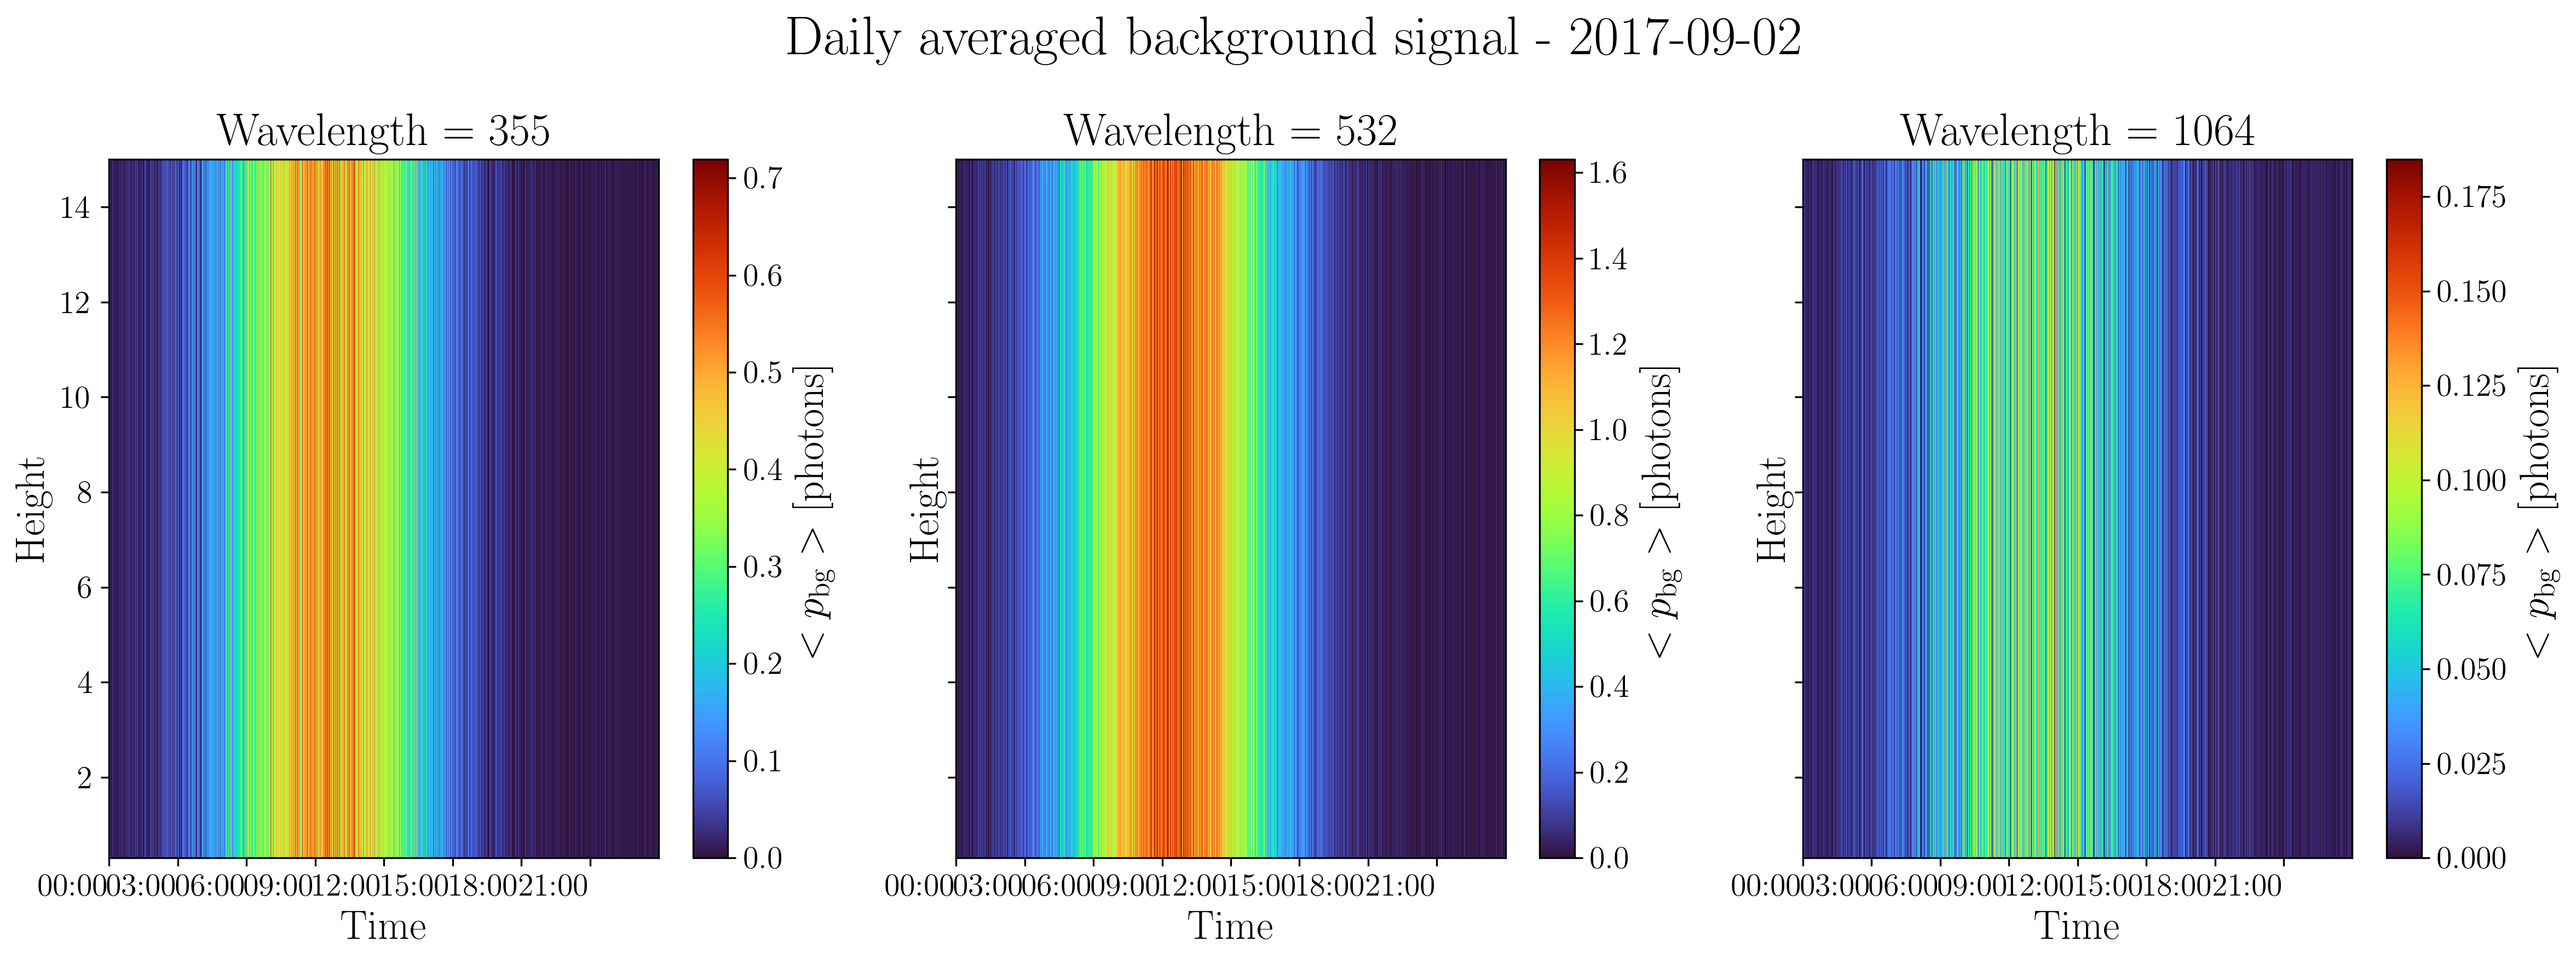

2017-09-02 00:00:00


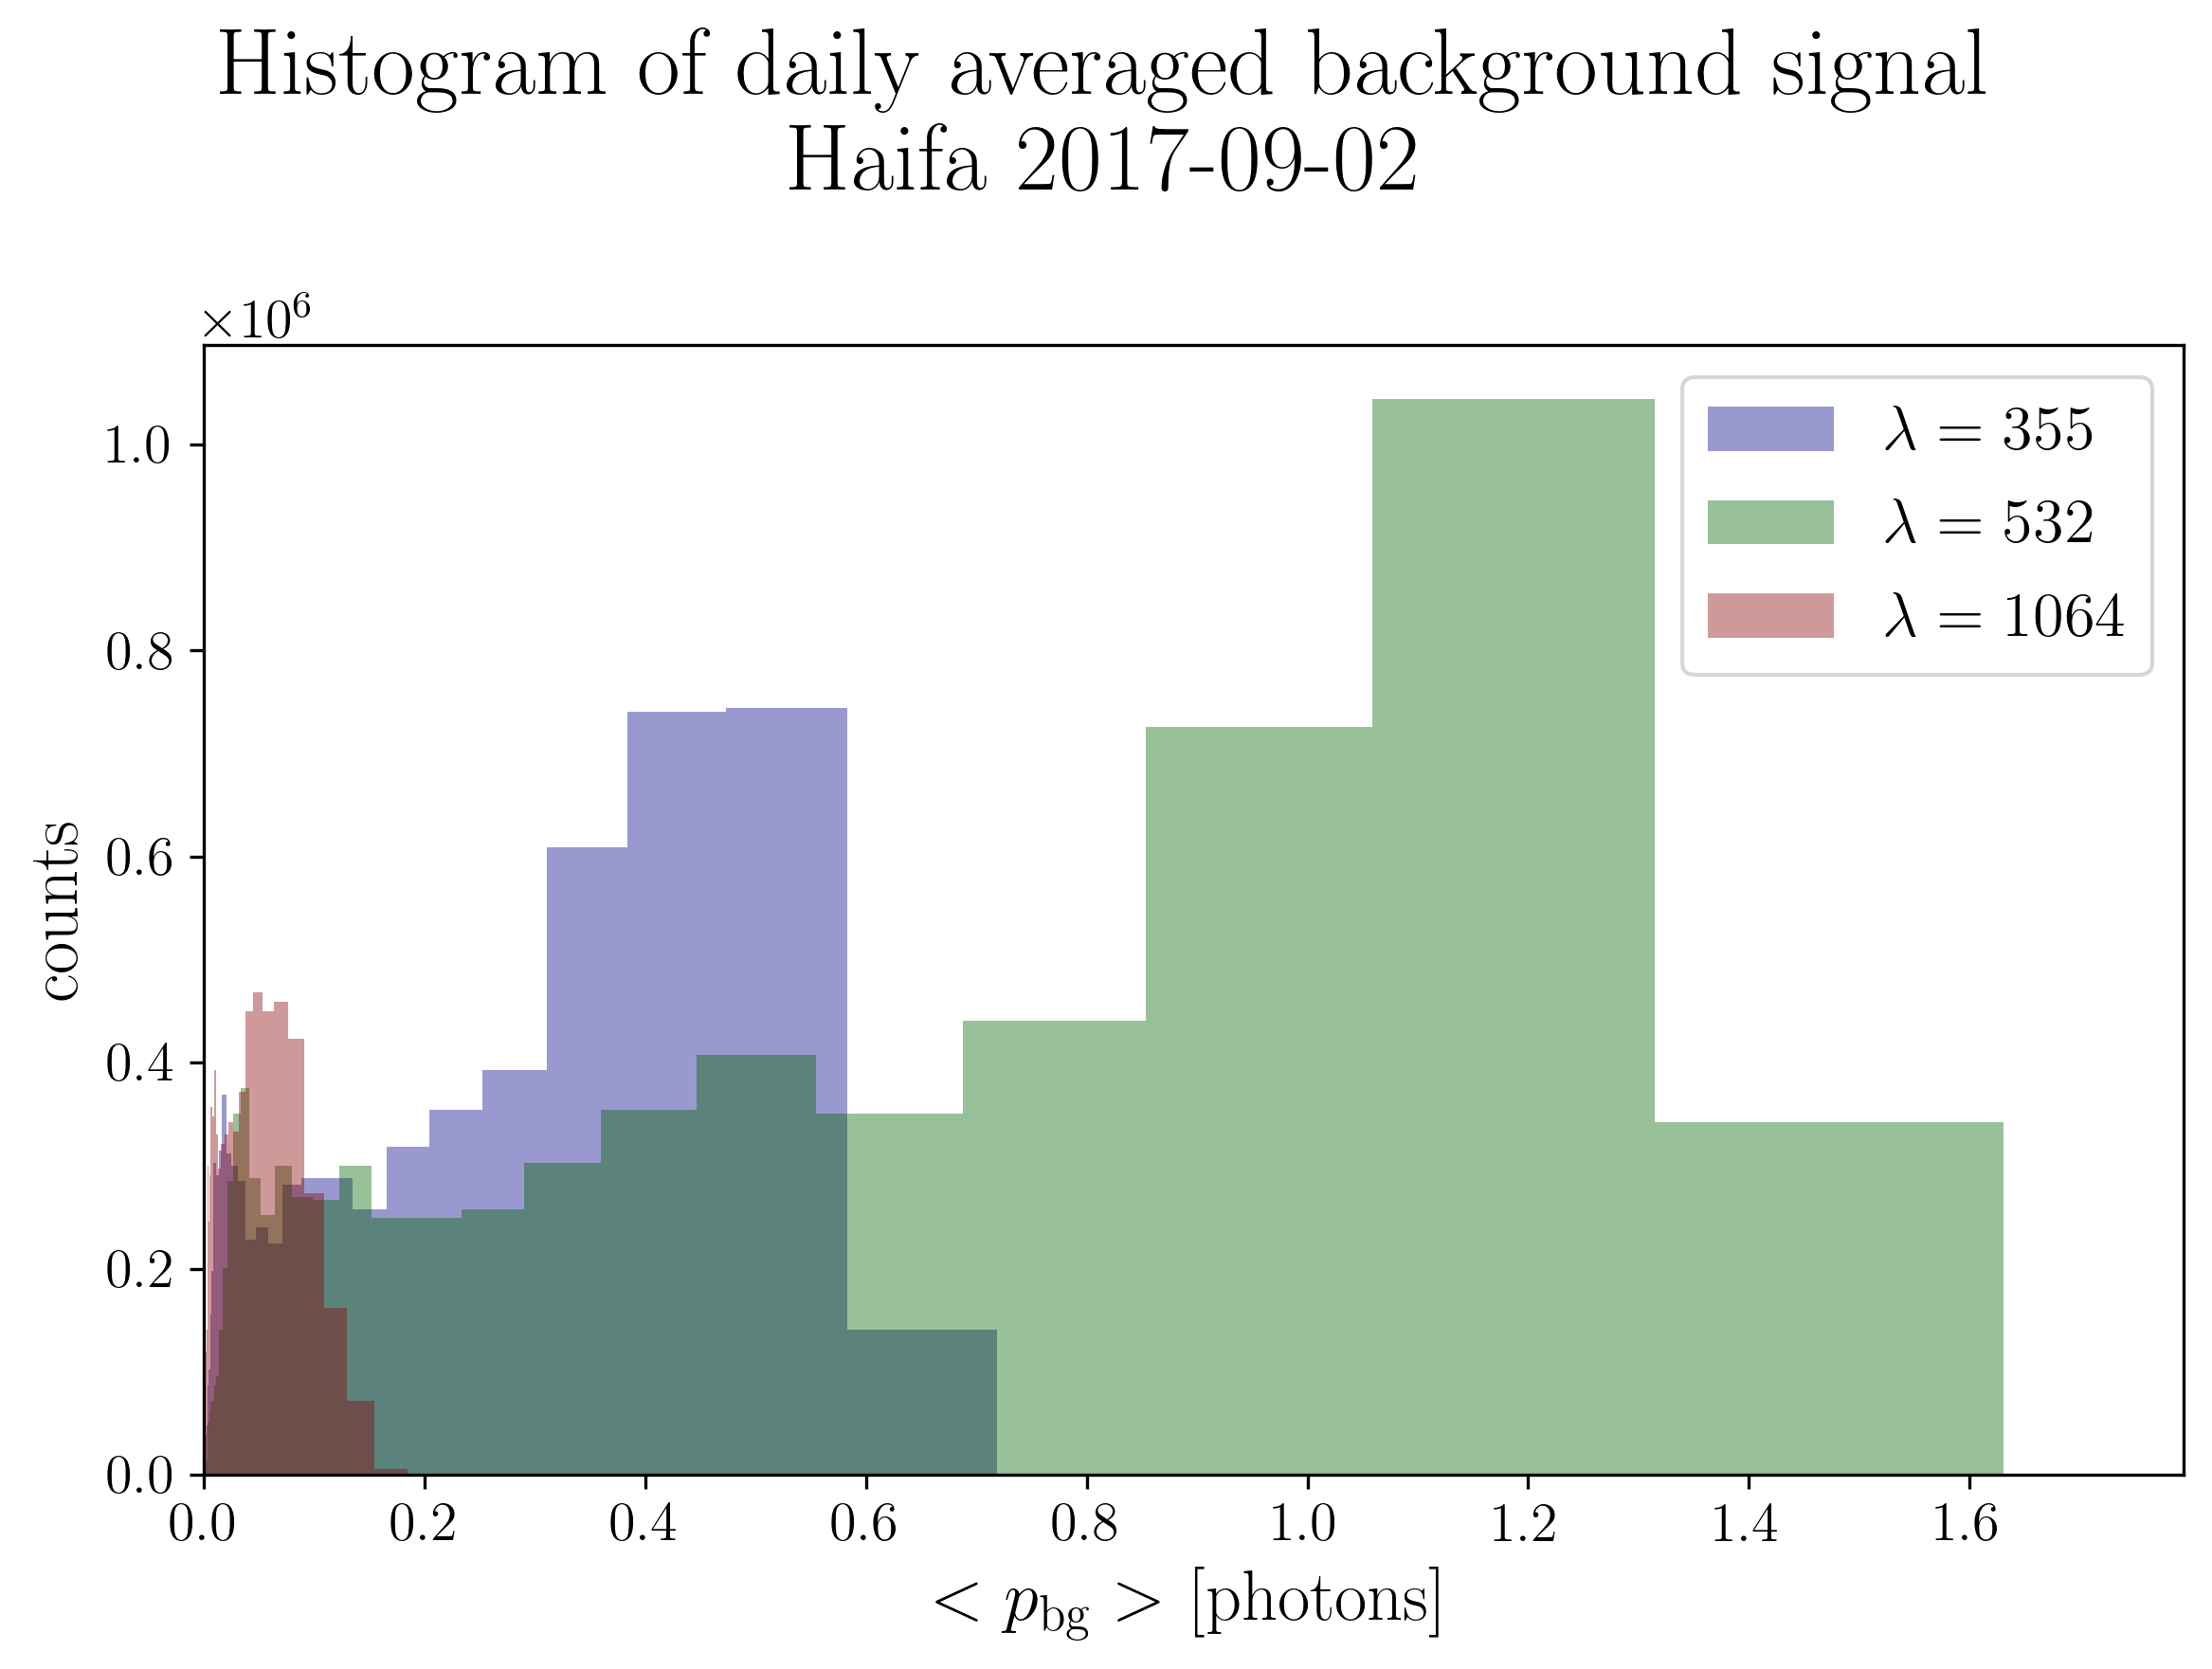

wavelength [nm] valid size % positive % negative % zeros %  mean   std
0             355       100.00      94.90       0.00    5.10  0.17  0.19
1             532       100.00      96.22       0.00    3.78  0.44  0.46
2            1064       100.00      93.37       0.00    6.63  0.03  0.03

In [4]:
p_bg = get_daily_bg(station, dt_day)  # daily background: p_bg
# Expand p_bg to coordinates : 'Wavelength','Height', 'Time
bg_ds = p_bg.broadcast_like(r2_da).to_dataset()
bg_ds['date'] = dt_day
bg_ds.attrs['location'] = station.location
custom_plot_xr(bg_ds.bg,height_slice=slice(0,15), figsize=(16,6))
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg',nbins=50)
bg_stats

# 2. Clean Lidar Signal

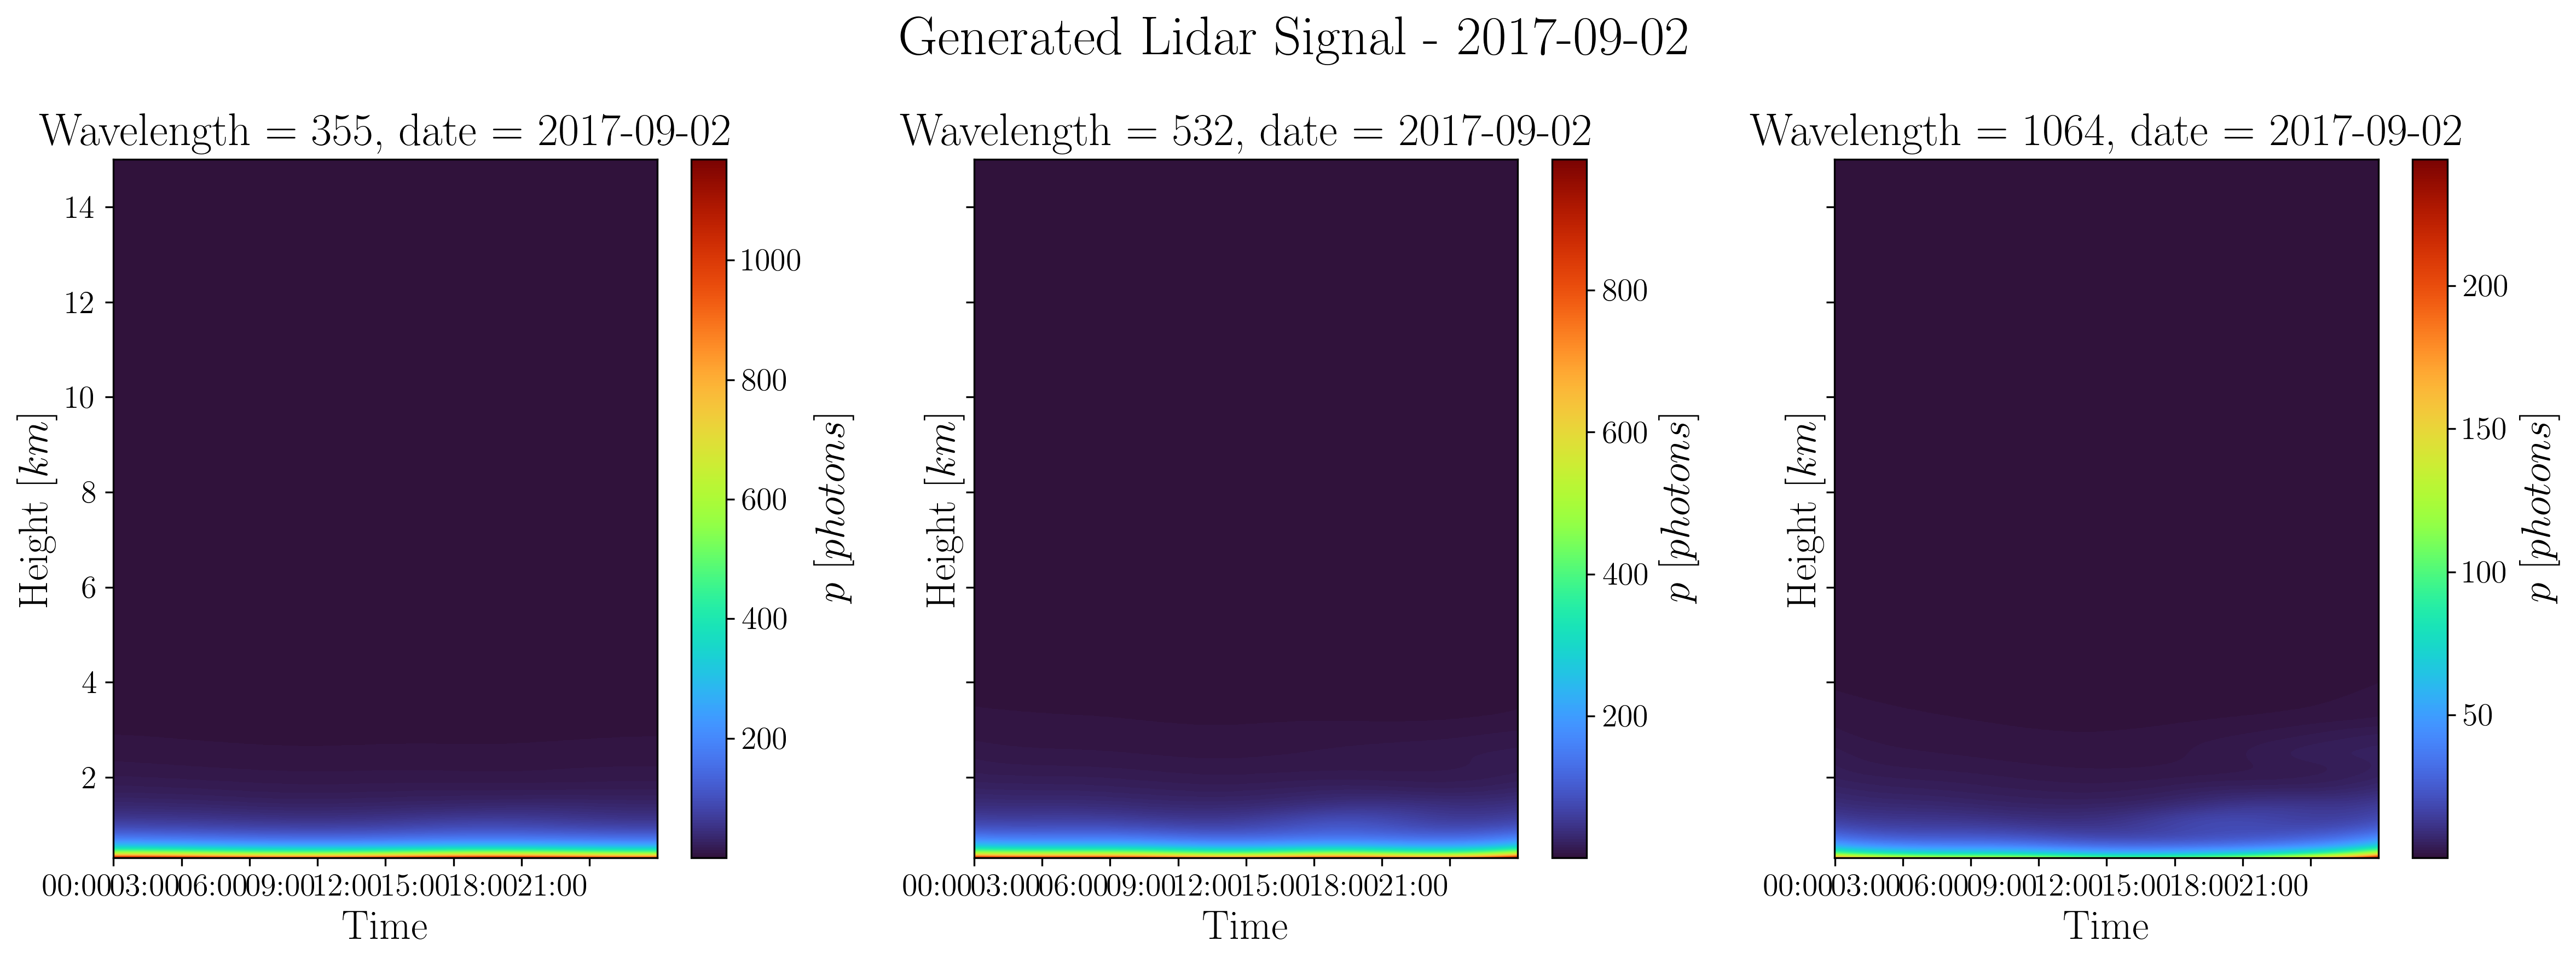

2017-09-02 00:00:00


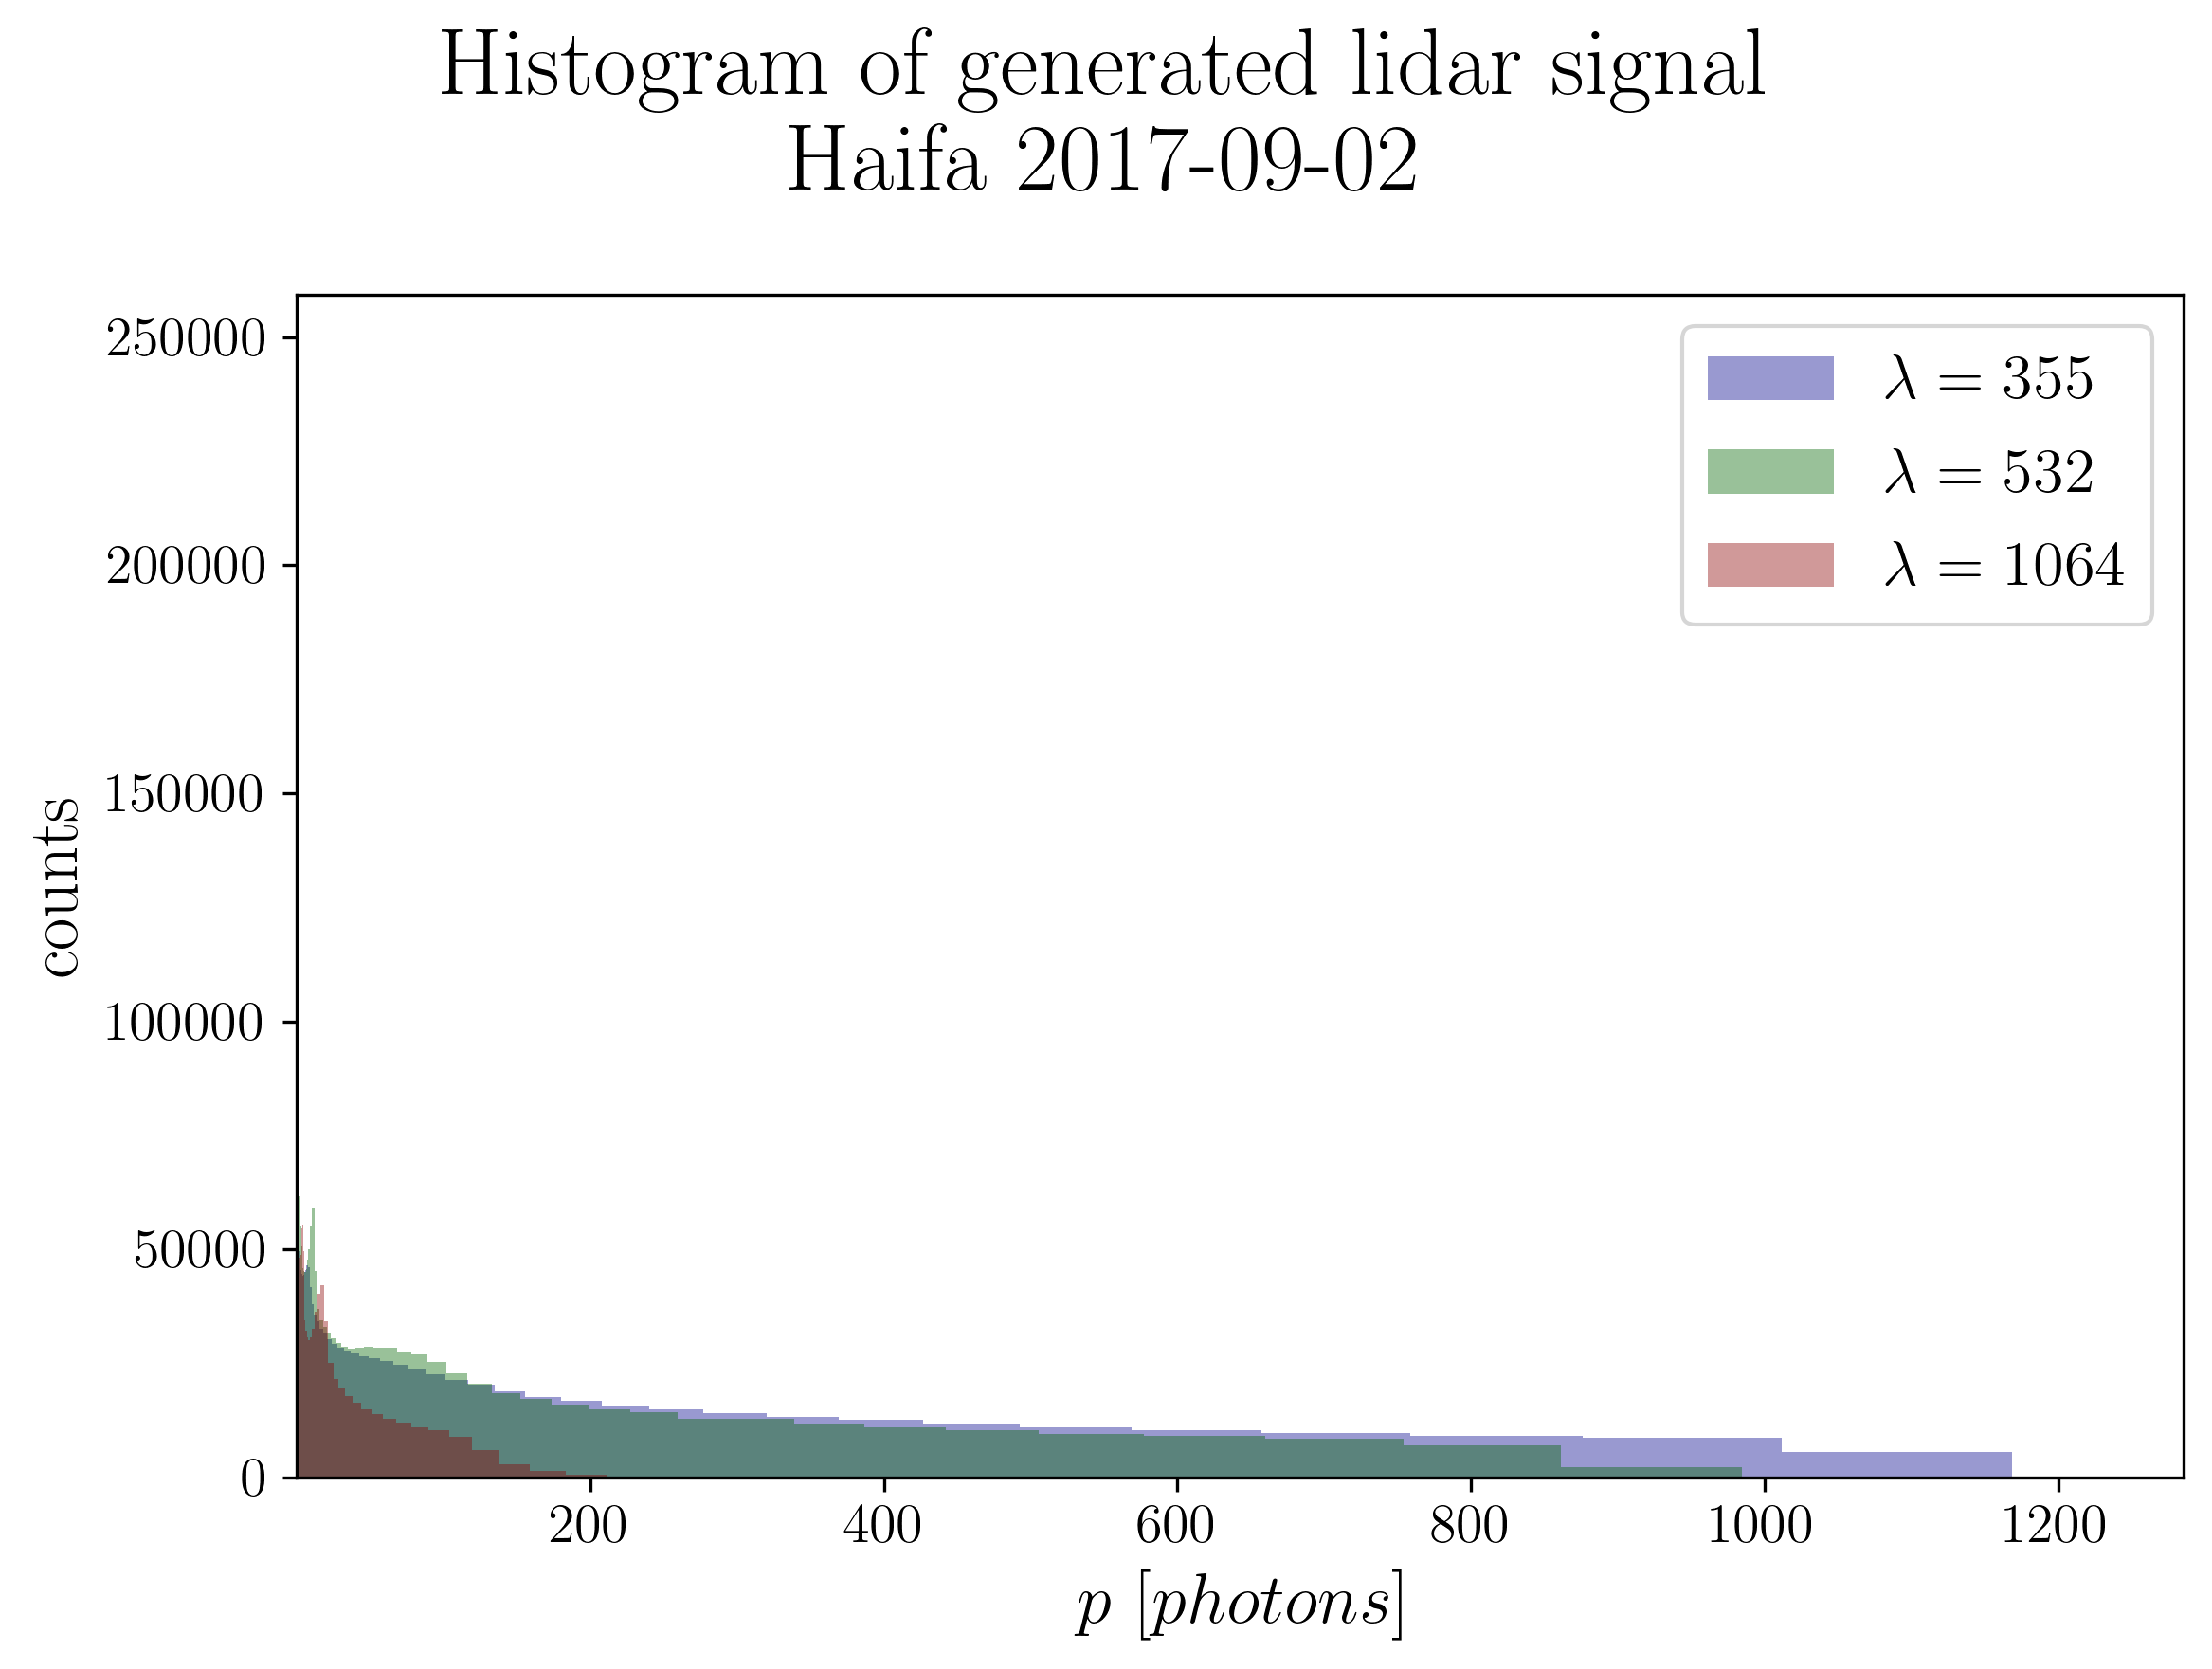

wavelength [nm] valid size % positive % negative % zeros %   mean    std
0             355       100.00     100.00       0.00    0.00  11.72  70.50
1             532       100.00     100.00       0.00    0.00  10.45  57.40
2            1064       100.00     100.00       0.00    0.00   1.94   9.83

In [5]:
signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,dt_day)
signal_nc_name = os.path.join(signal_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='signal'))
signal_ds = prep.load_dataset(signal_nc_name)
custom_plot_xr(signal_ds.p,height_slice=slice(0,15), figsize=(16,6))
_,_,p_stats= daily_ds_histogram(signal_ds, profile_type='p')#,log_scale=True)
p_stats

# 3. Lidar measurement

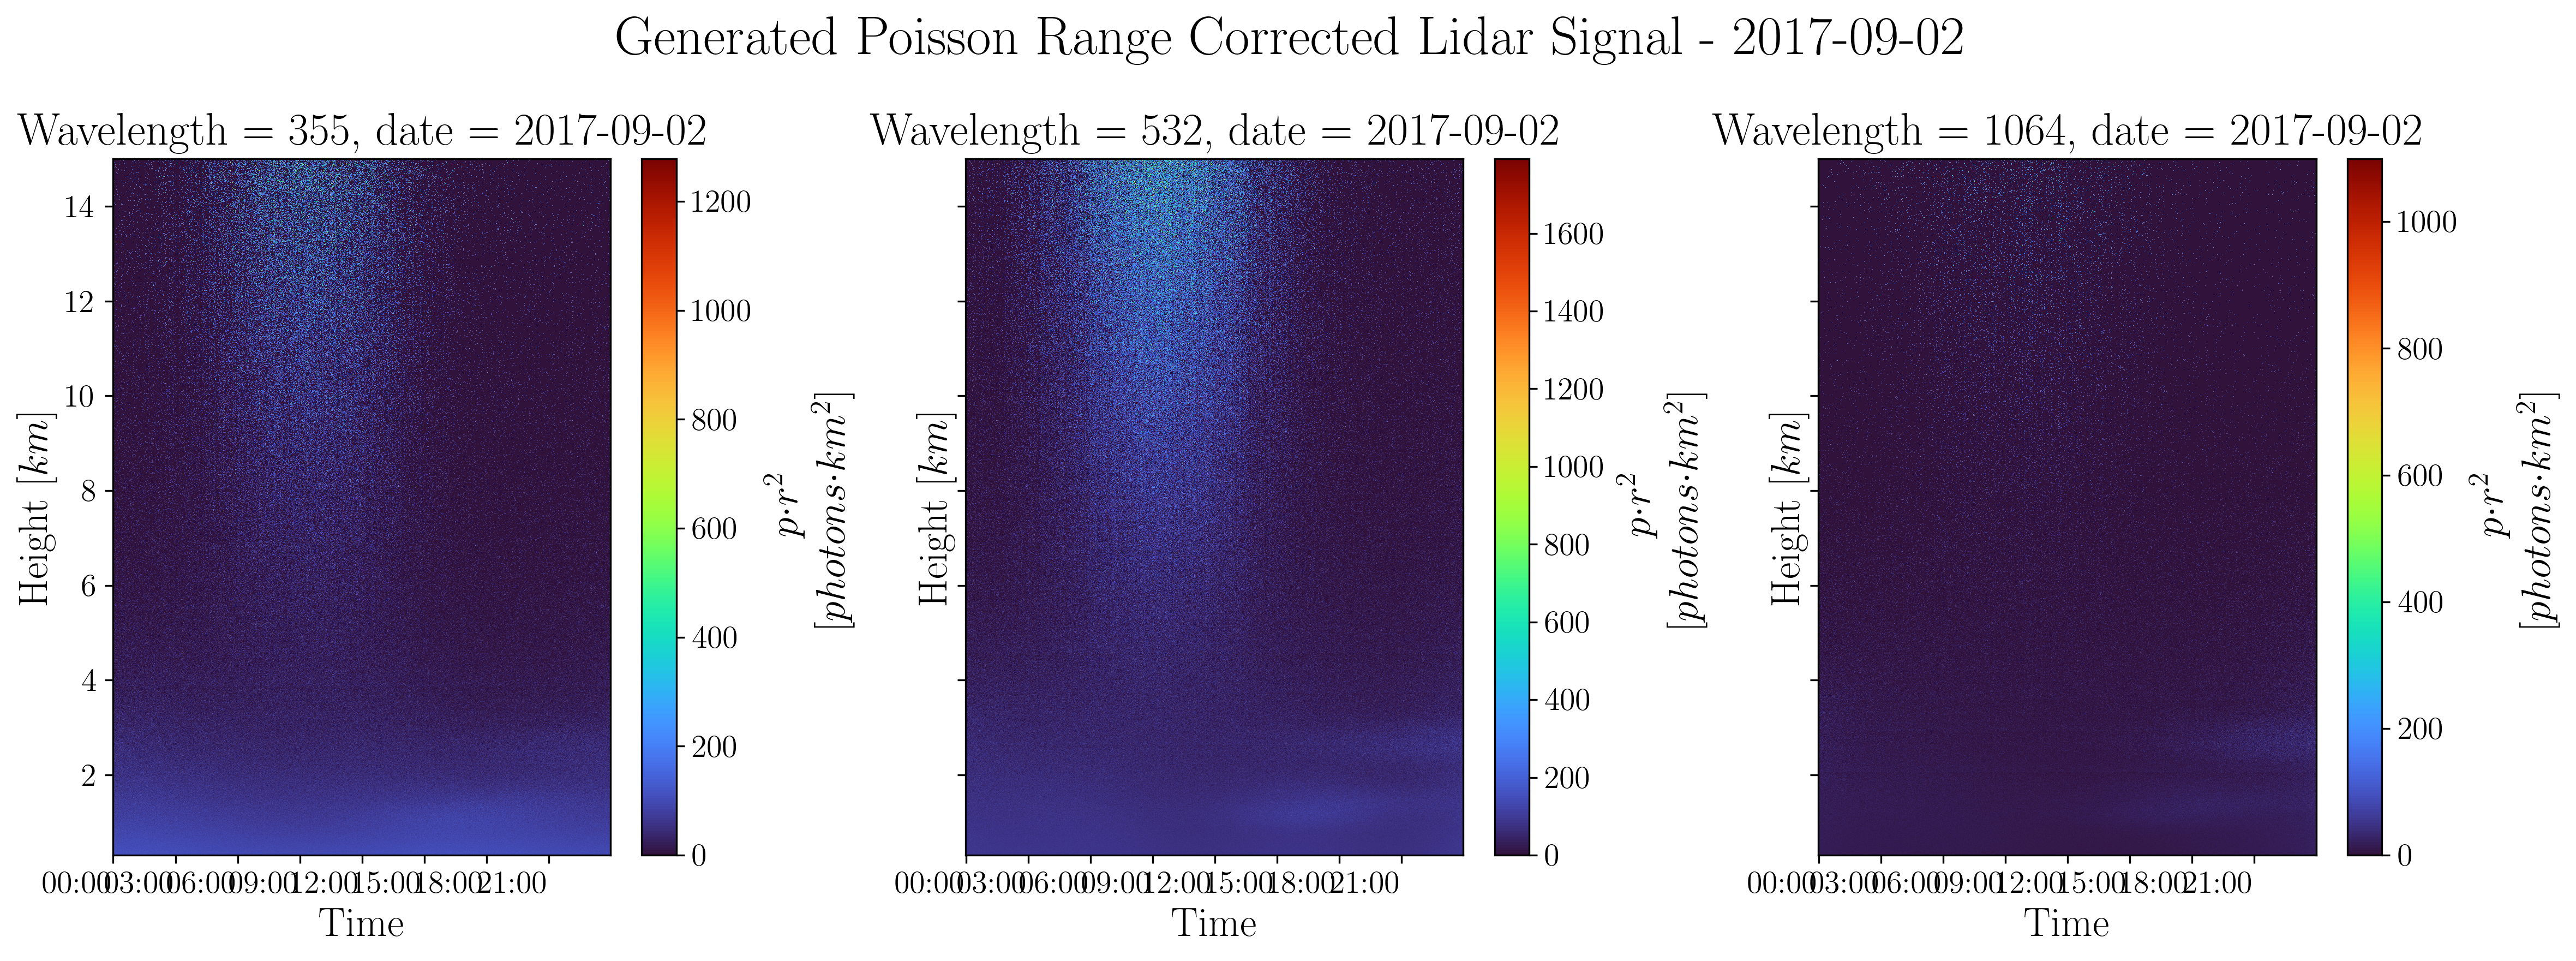

2017-09-02 00:00:00


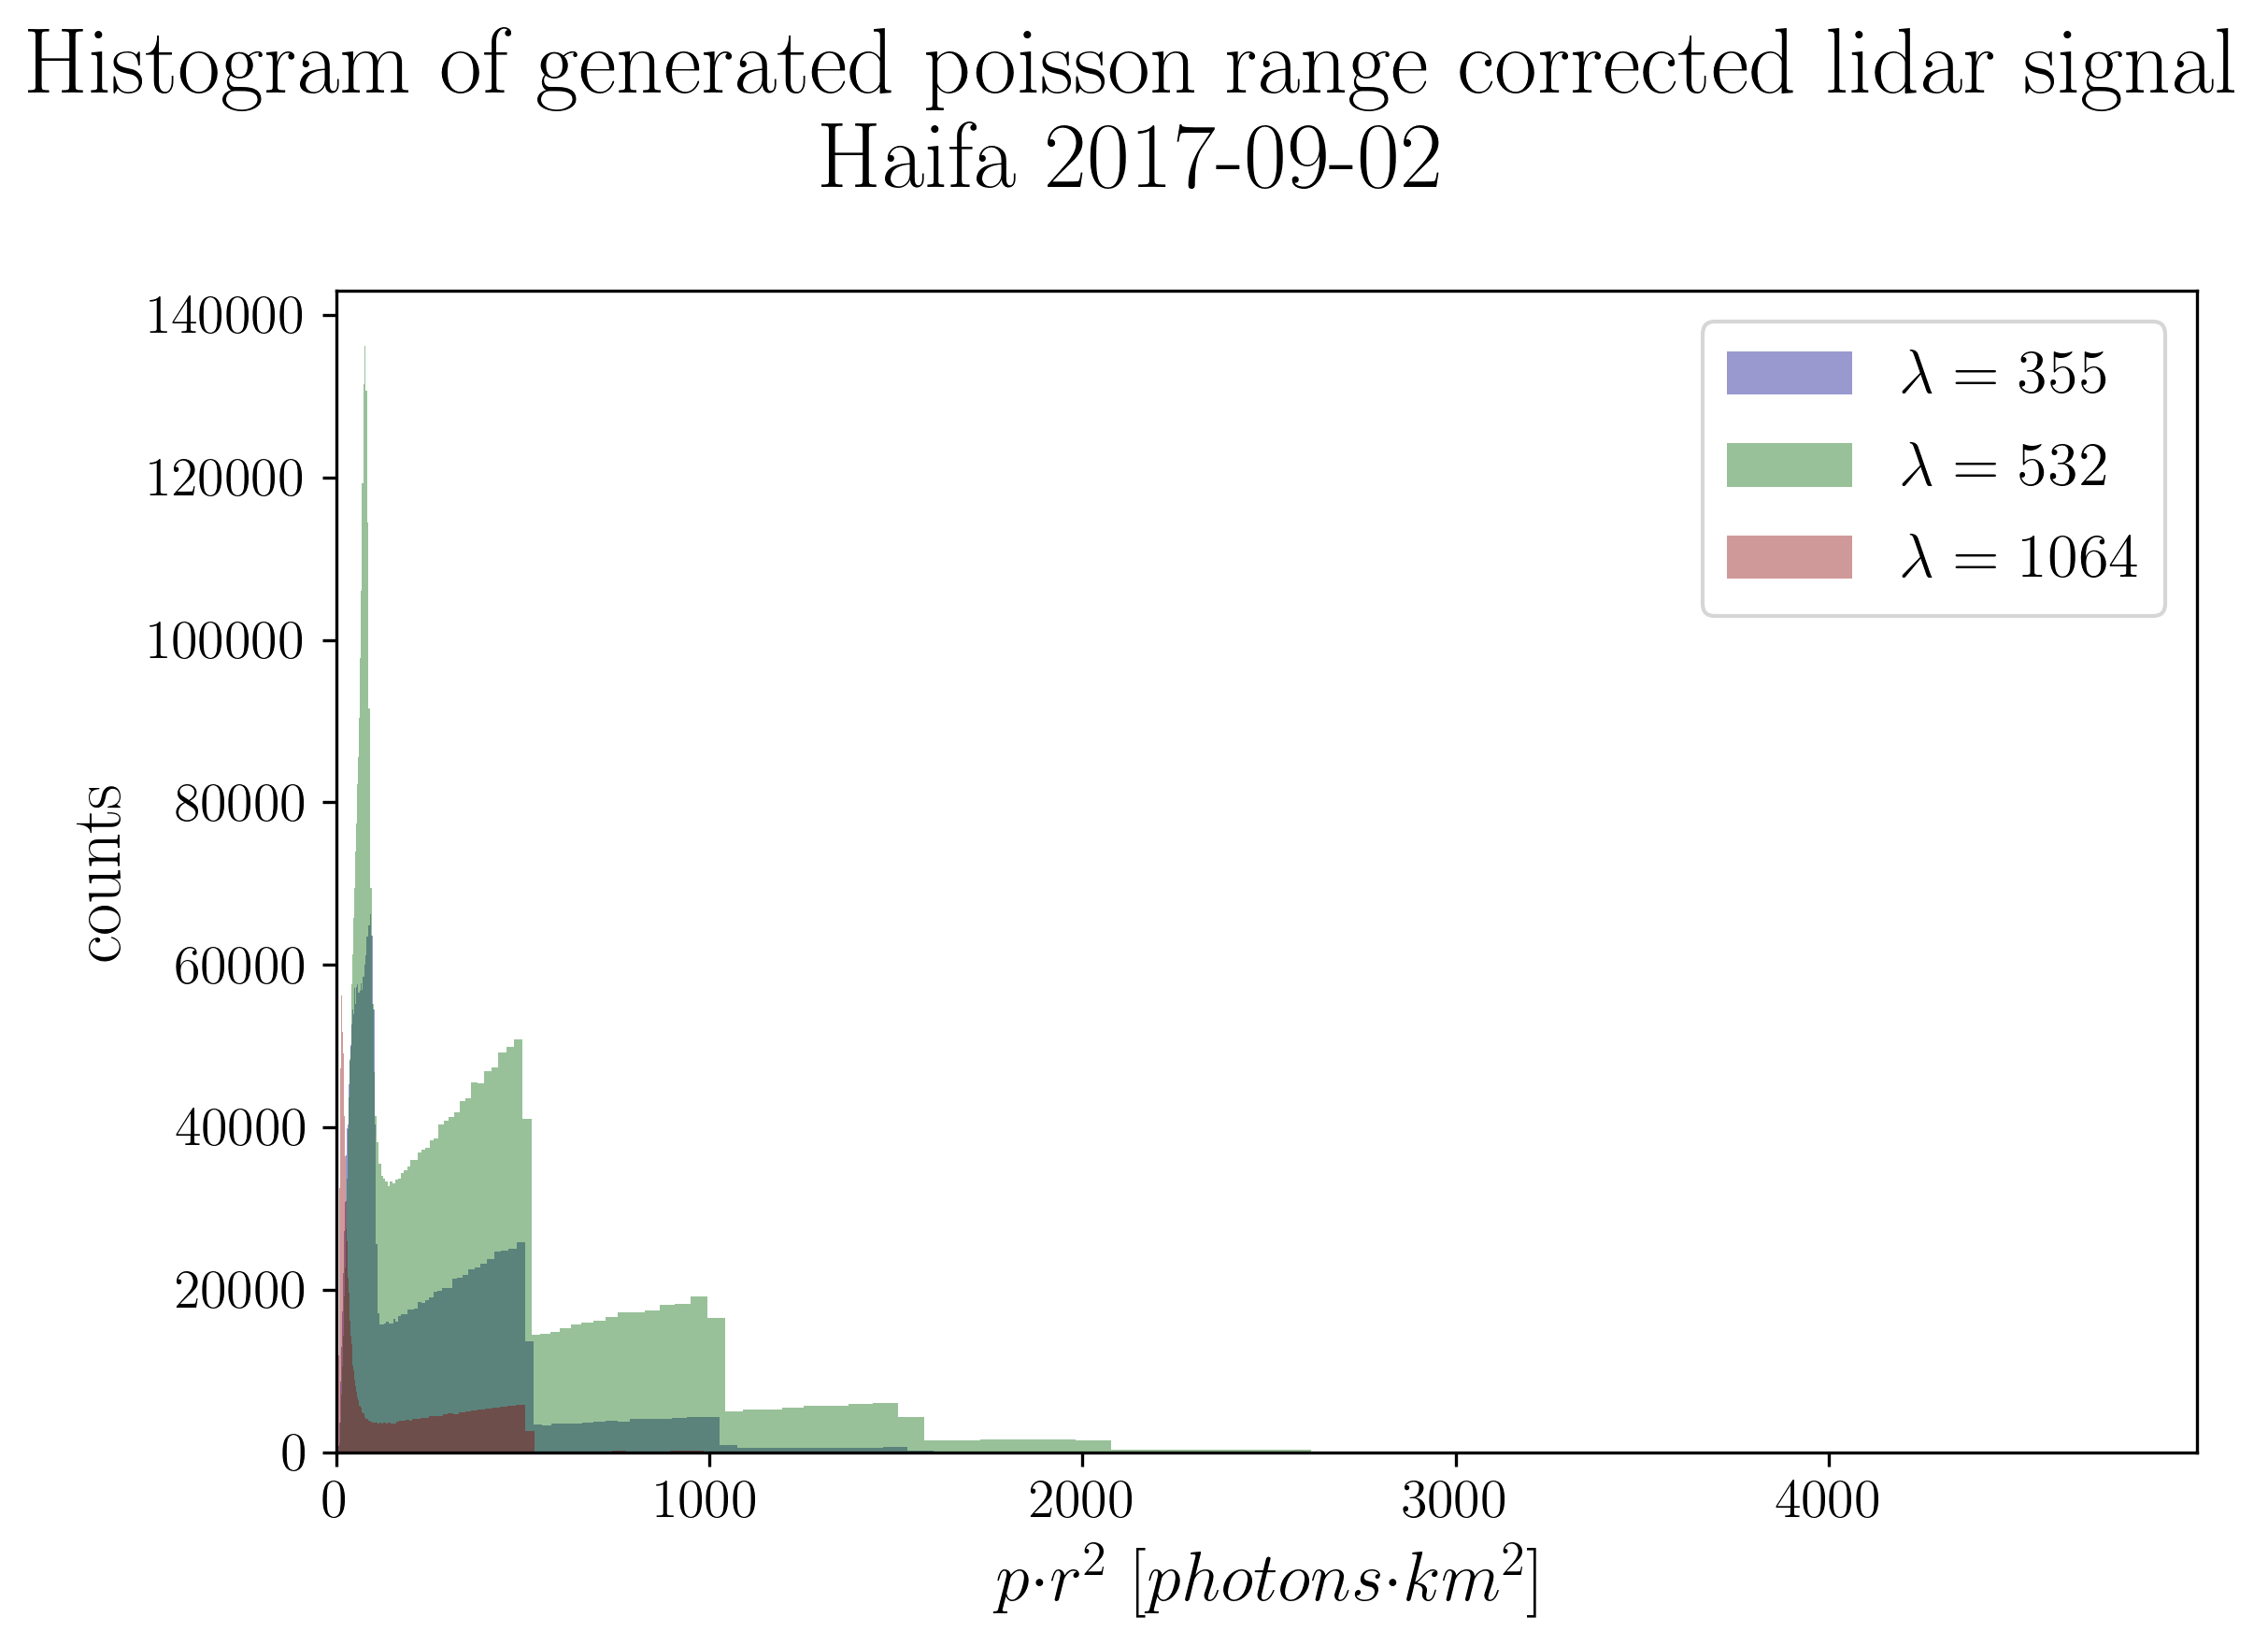

wavelength [nm] valid size % positive % negative % zeros %   mean     std
0             355       100.00      32.75       0.00   67.25  41.06  108.87
1             532       100.00      47.27       0.00   52.73  91.76  197.27
2            1064       100.00      19.29       0.00   80.71   8.66   42.14

In [6]:
lidar_folder = prep.get_month_folder_name(station.gen_lidar_dataset,dt_day)
lidar_nc_name = os.path.join(lidar_folder,gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='lidar'))
lidar_ds = prep.load_dataset(lidar_nc_name)
custom_plot_xr(lidar_ds.p,height_slice=slice(0,15), figsize=(16,6))
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p',nbins=150)#,log_scale=True)
lidar_stats

# 4. Clean range corrected Signal

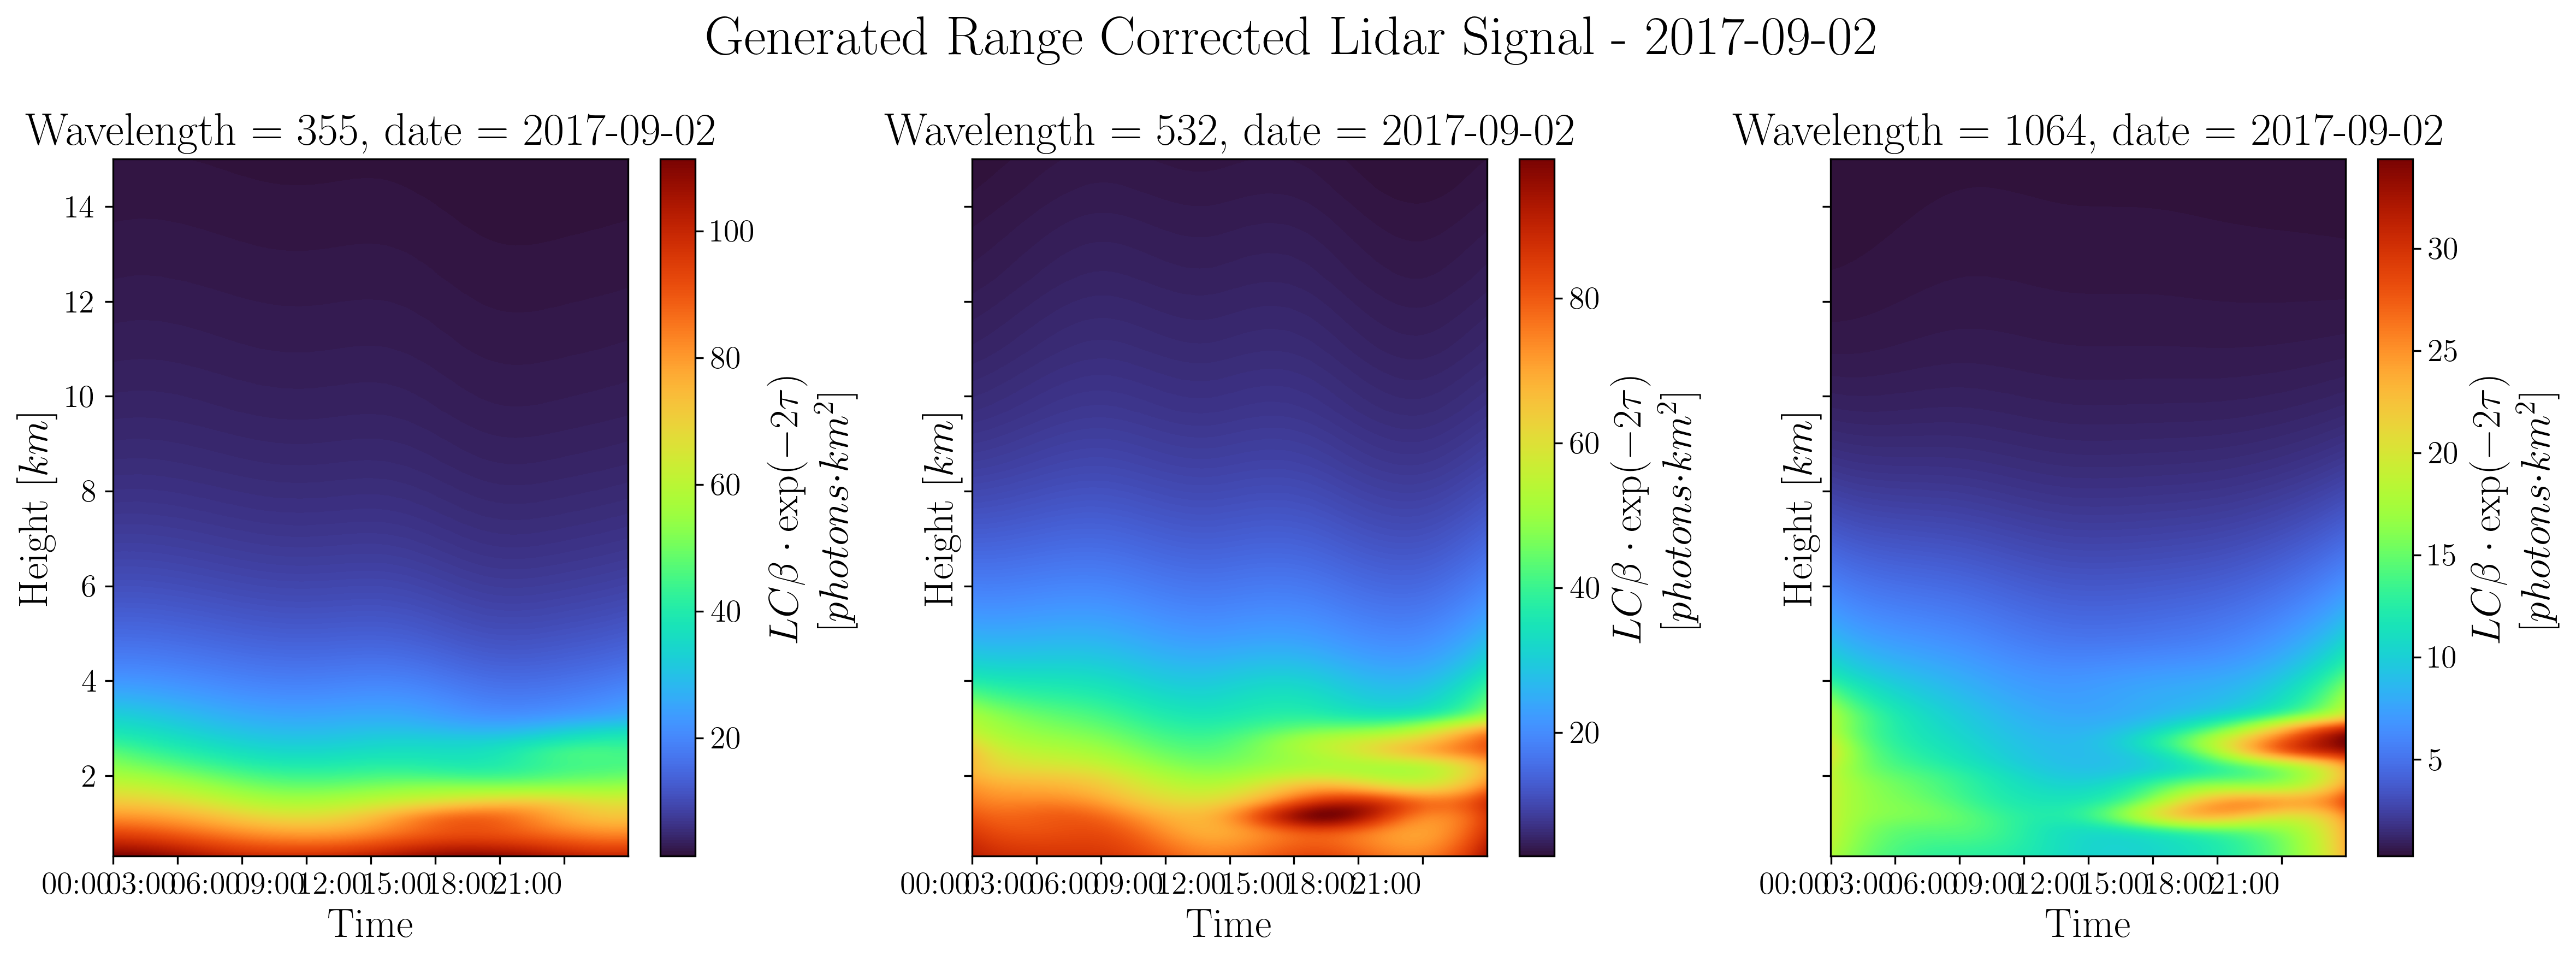

2017-09-02 00:00:00


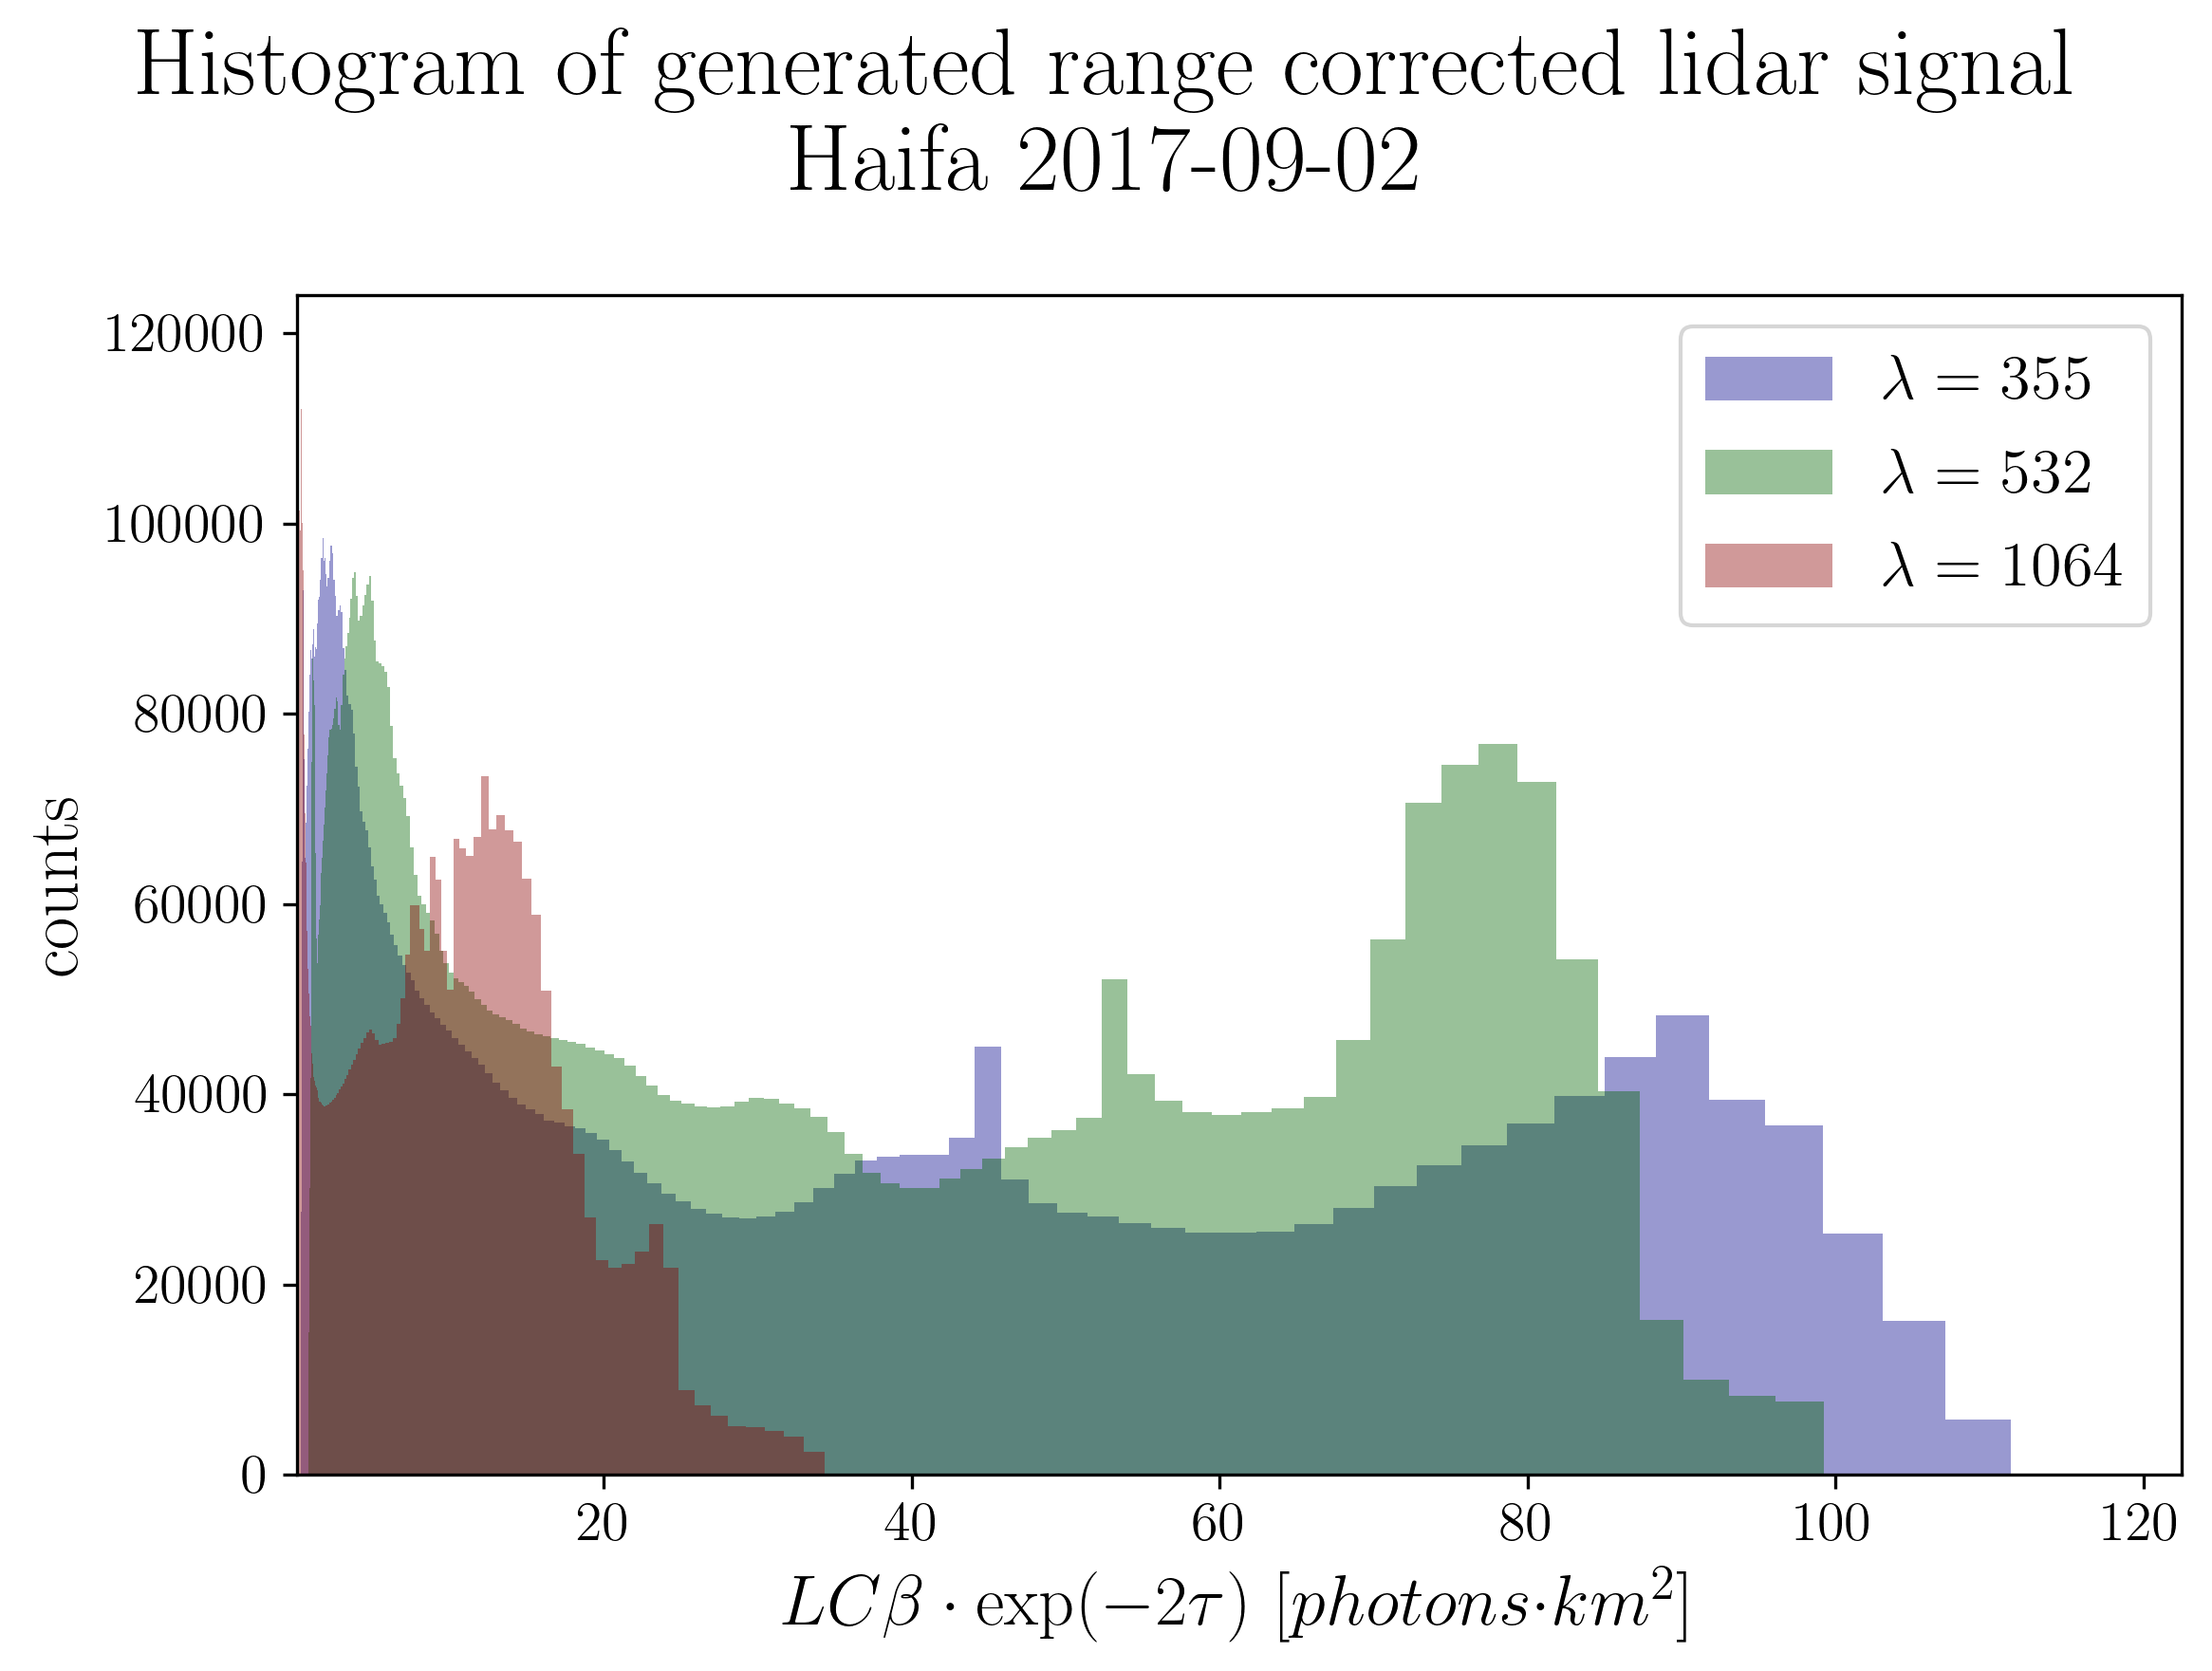

wavelength [nm] valid size % positive % negative % zeros %   mean    std
0             355       100.00     100.00       0.00    0.00  11.46  20.85
1             532       100.00     100.00       0.00    0.00  15.47  21.50
2            1064       100.00     100.00       0.00    0.00   3.45   5.36

In [7]:
custom_plot_xr(signal_ds.range_corr,height_slice=slice(0,15), figsize=(16,6))
_,_,pr2_stats= daily_ds_histogram(signal_ds, profile_type='range_corr',nbins=150)#,log_scale=True)
pr2_stats

# 5. Lidar range corrected measurement

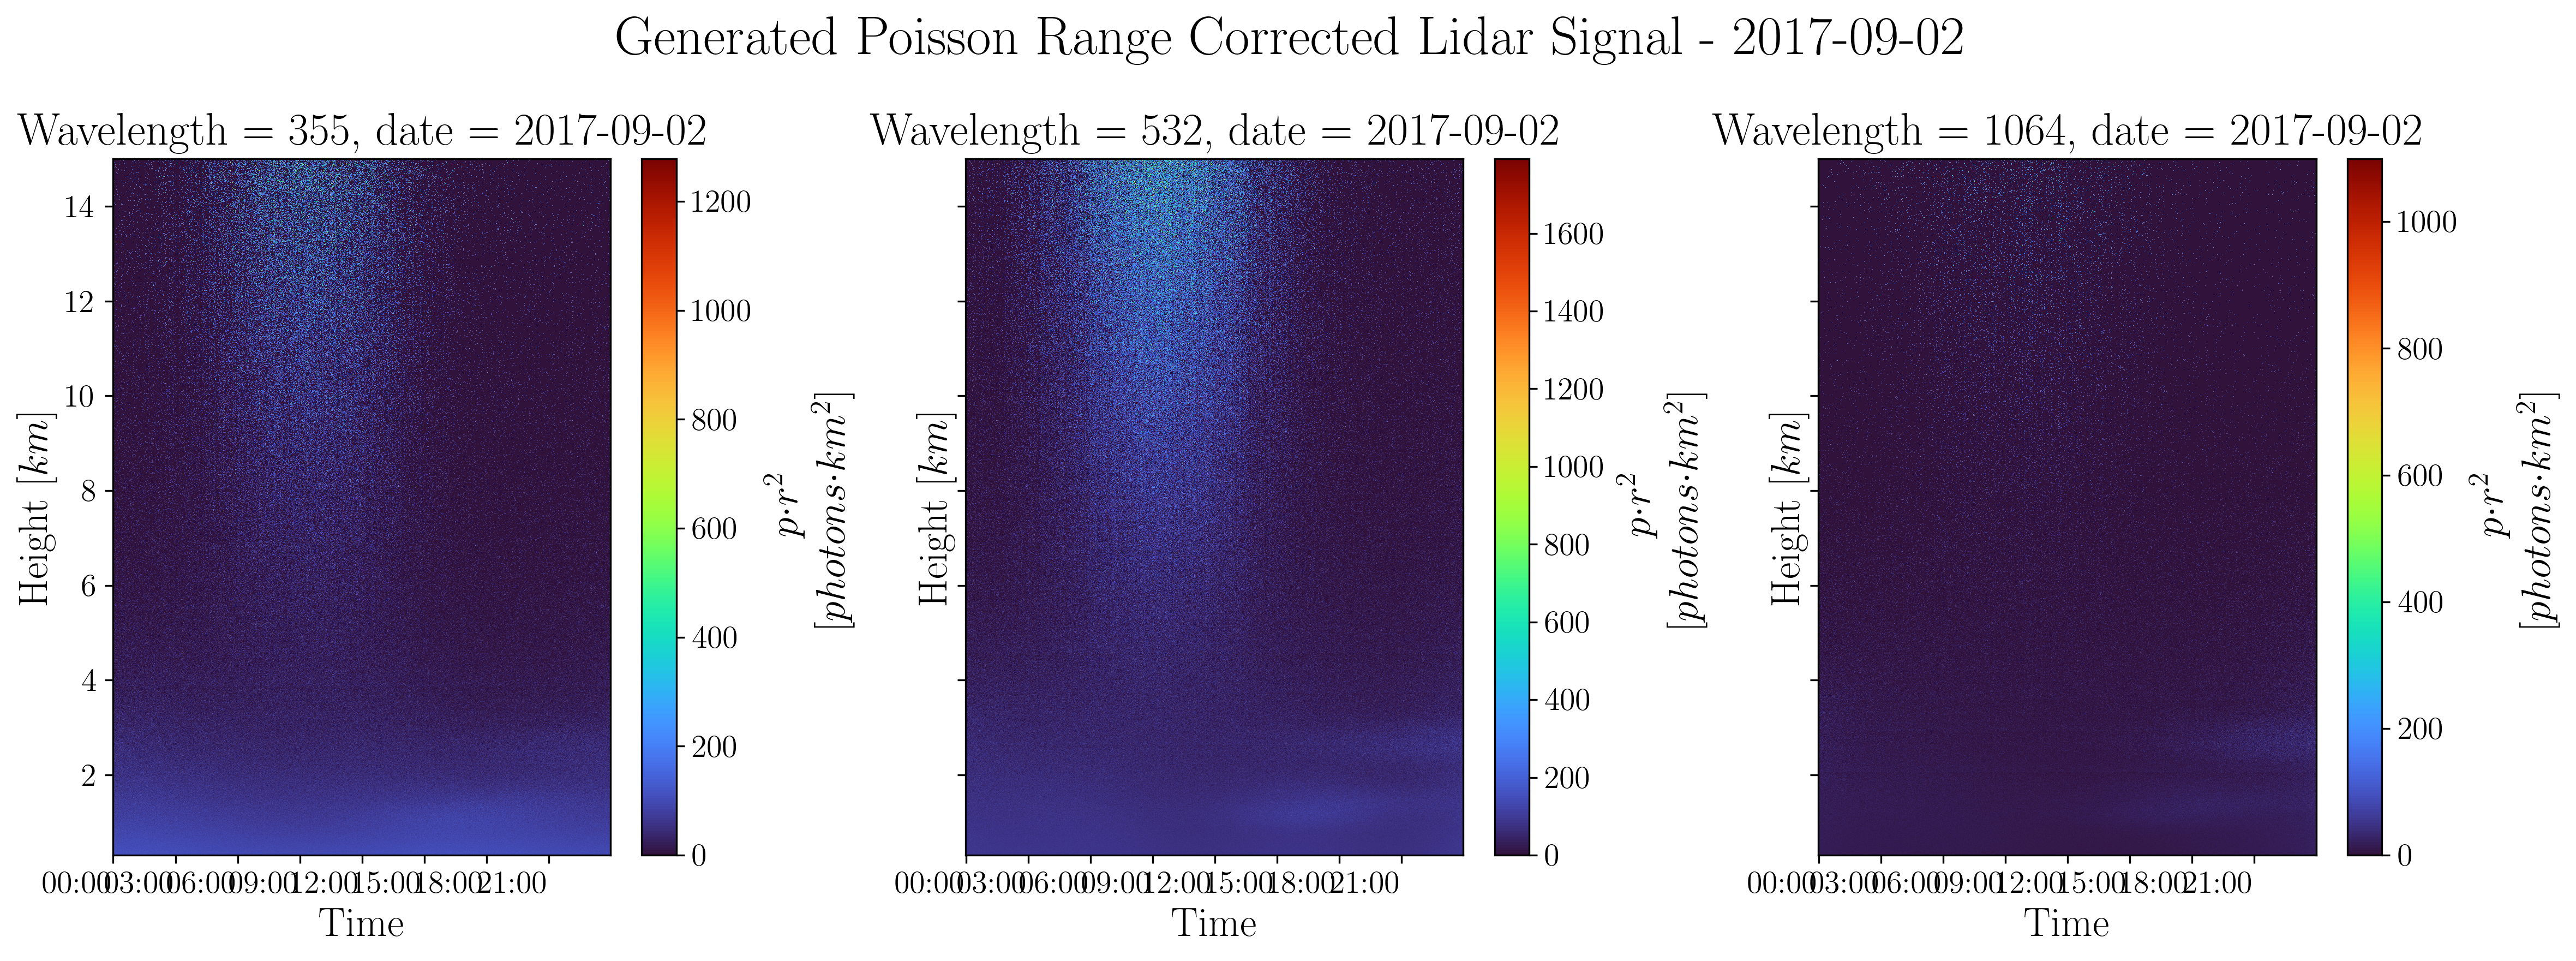

2017-09-02 00:00:00


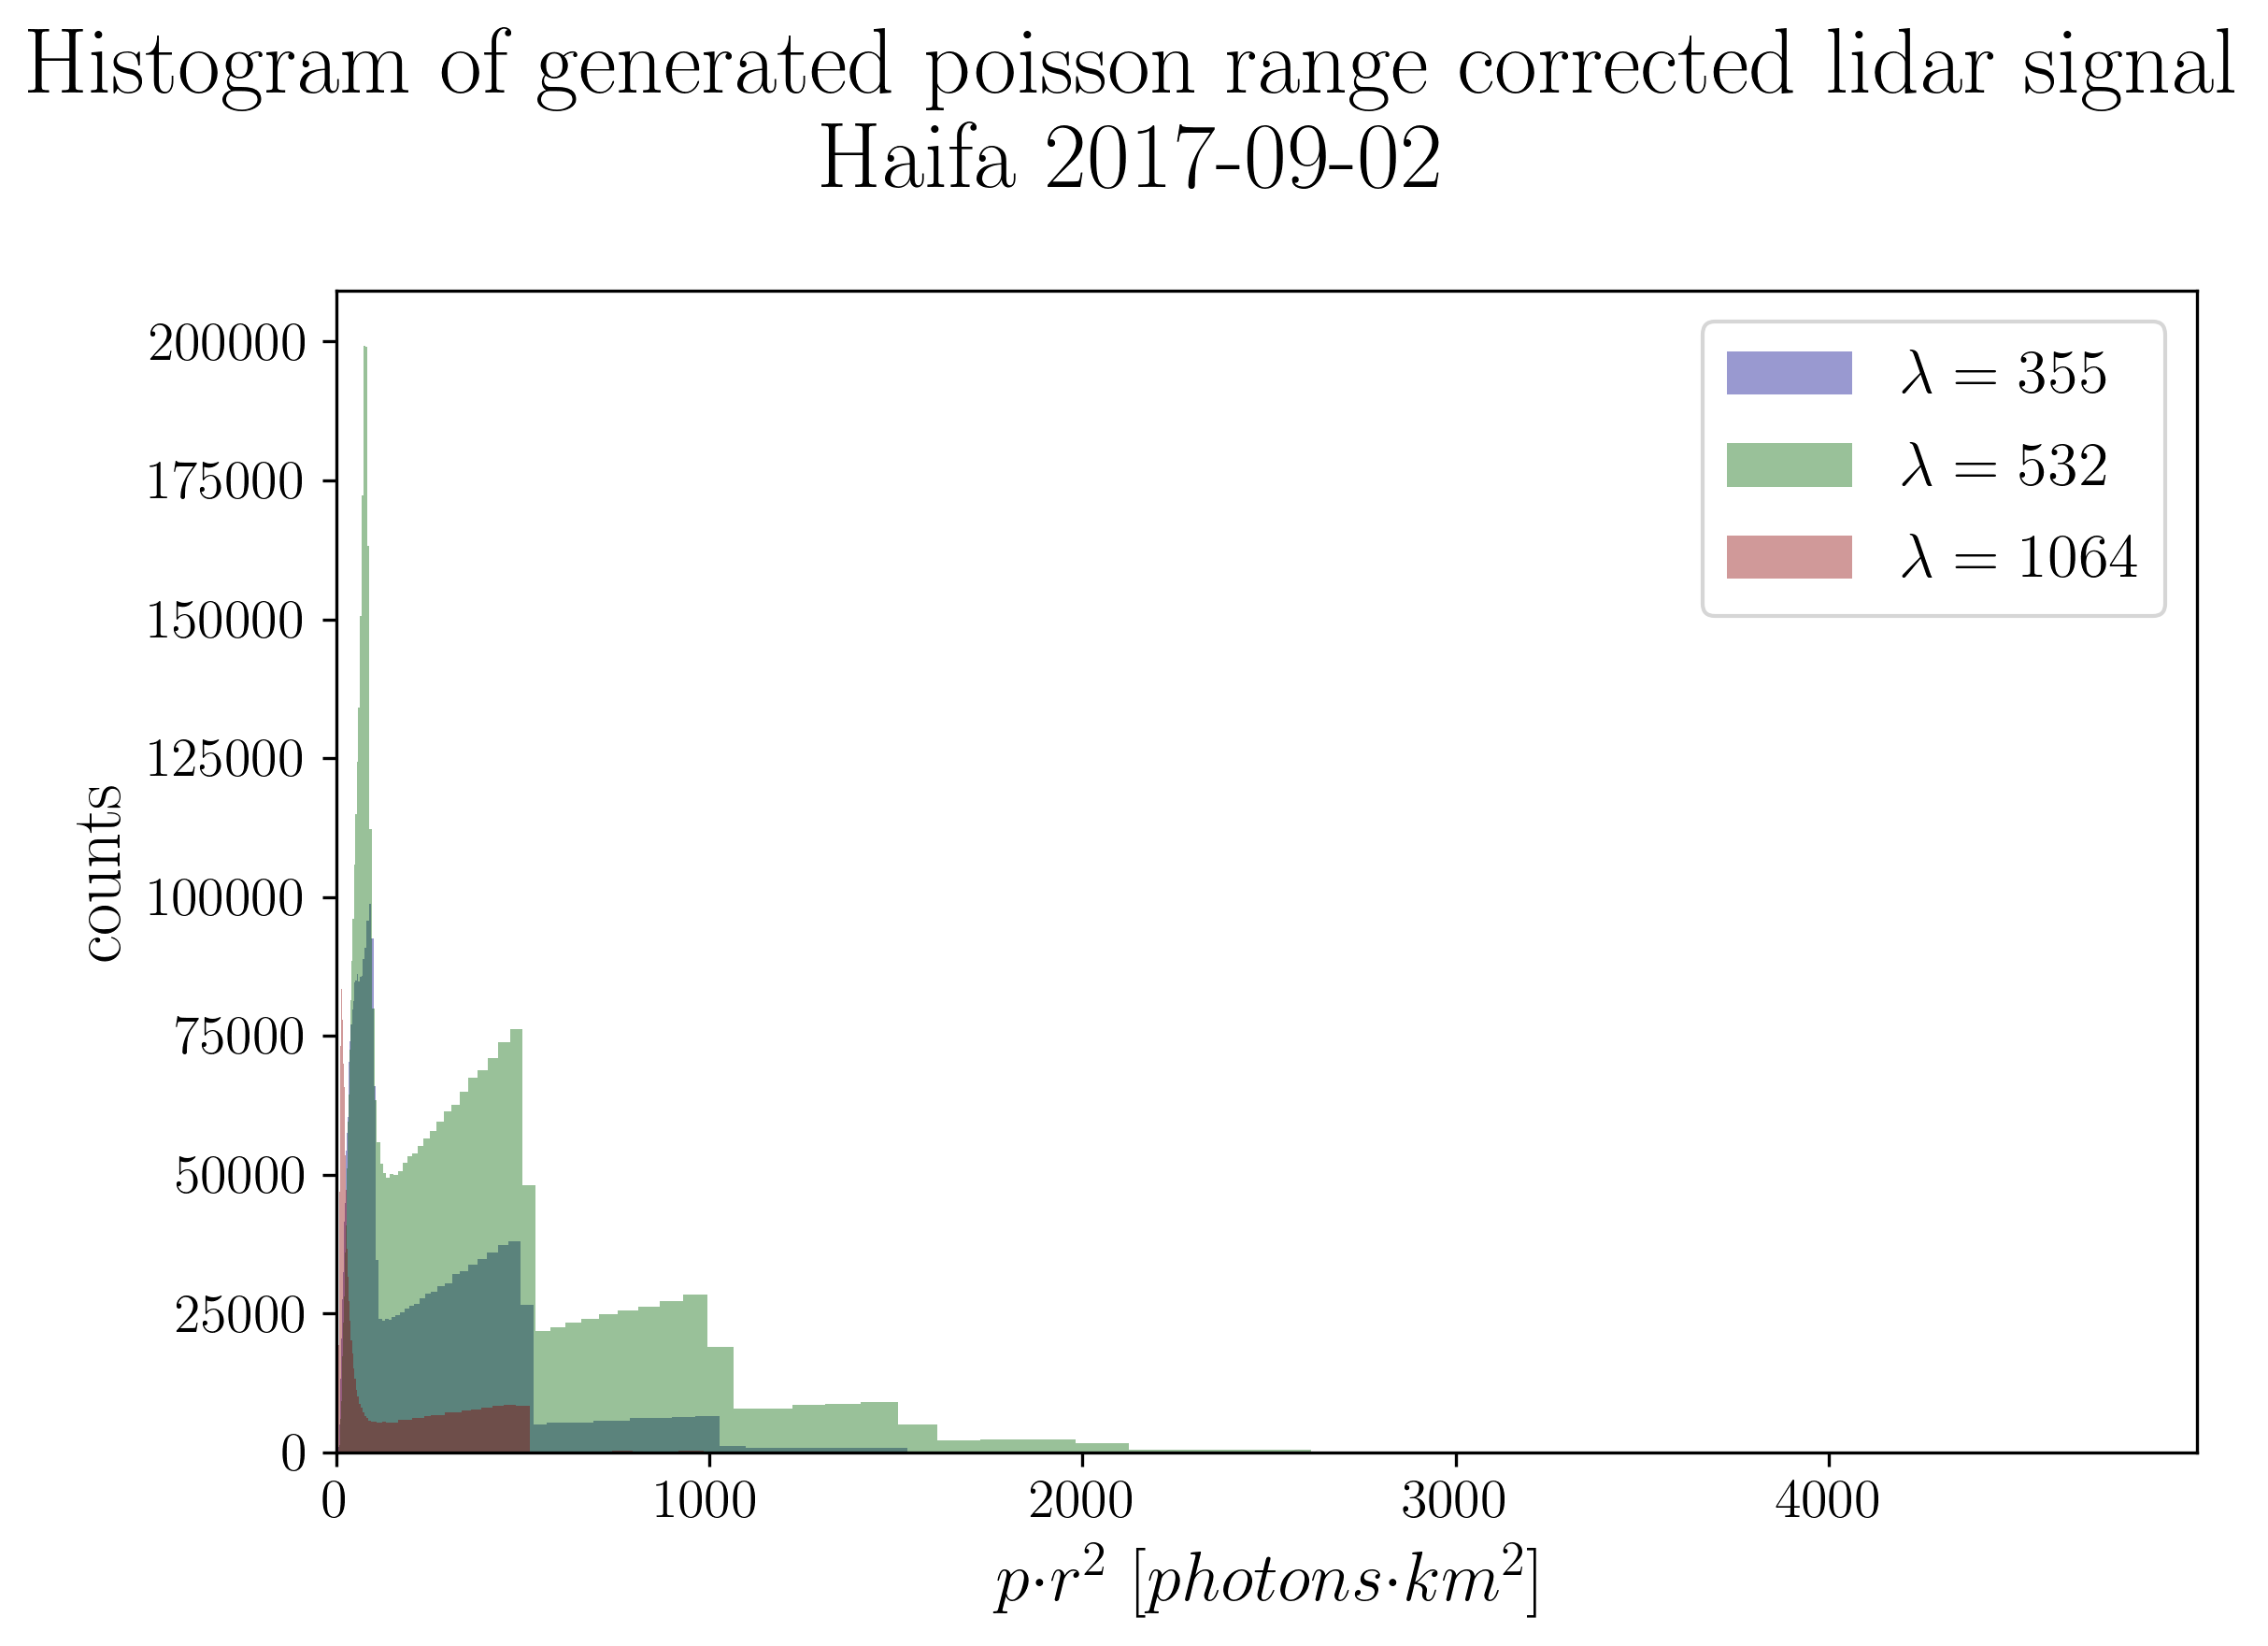

wavelength [nm] valid size % positive % negative % zeros %   mean     std
0             355       100.00      32.75       0.00   67.25  41.06  108.87
1             532       100.00      47.27       0.00   52.73  91.76  197.27
2            1064       100.00      19.29       0.00   80.71   8.66   42.14

In [8]:
custom_plot_xr(lidar_ds.range_corr,height_slice=slice(0,15), figsize=(16,6))
_,_,pr2n_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr',nbins=100)#,log_scale=True)
pr2n_stats

# 6. Molecular signal (attenuated backscatter)

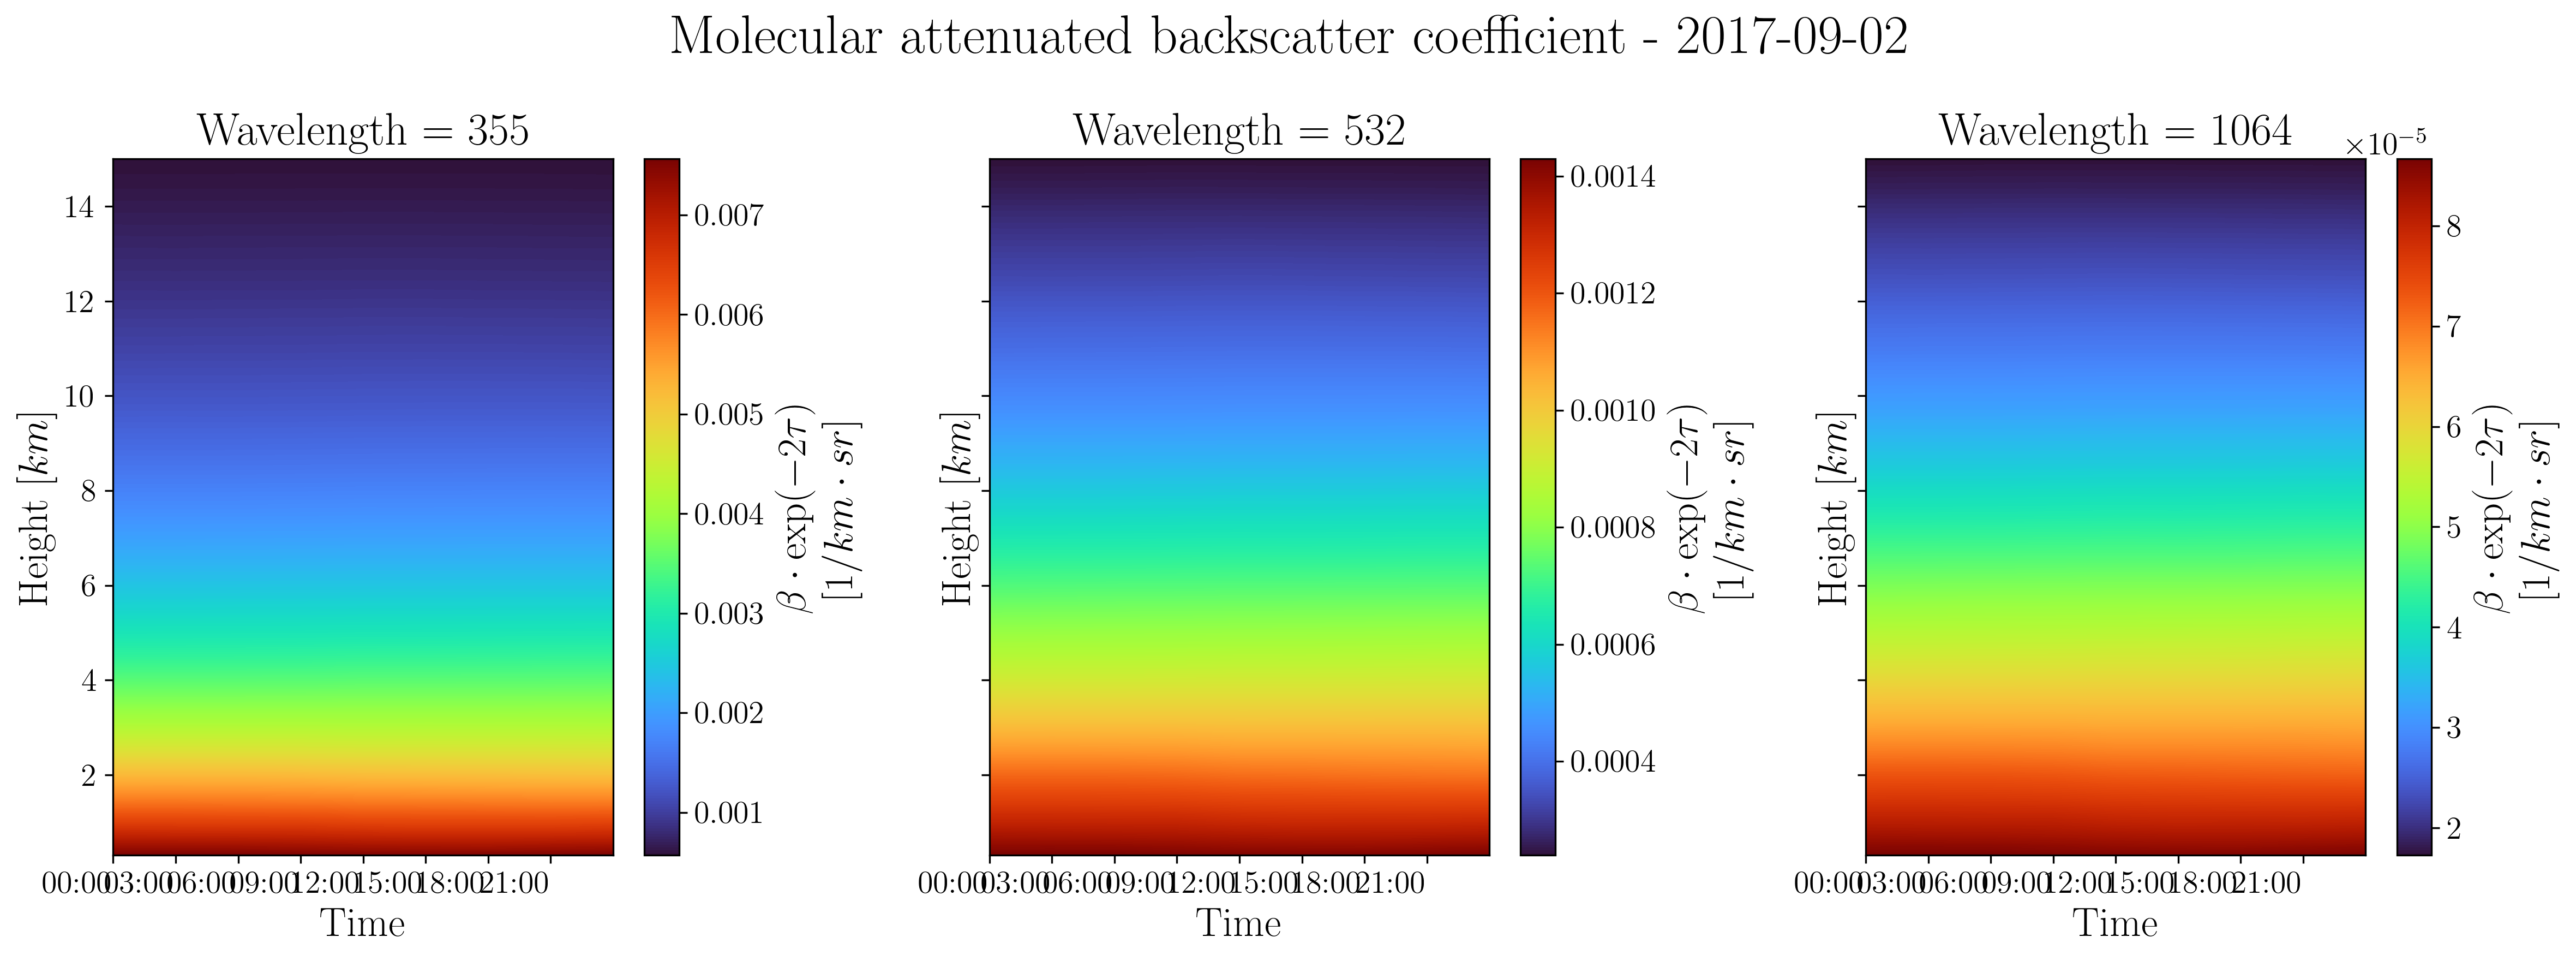

2017-09-02 00:00:00


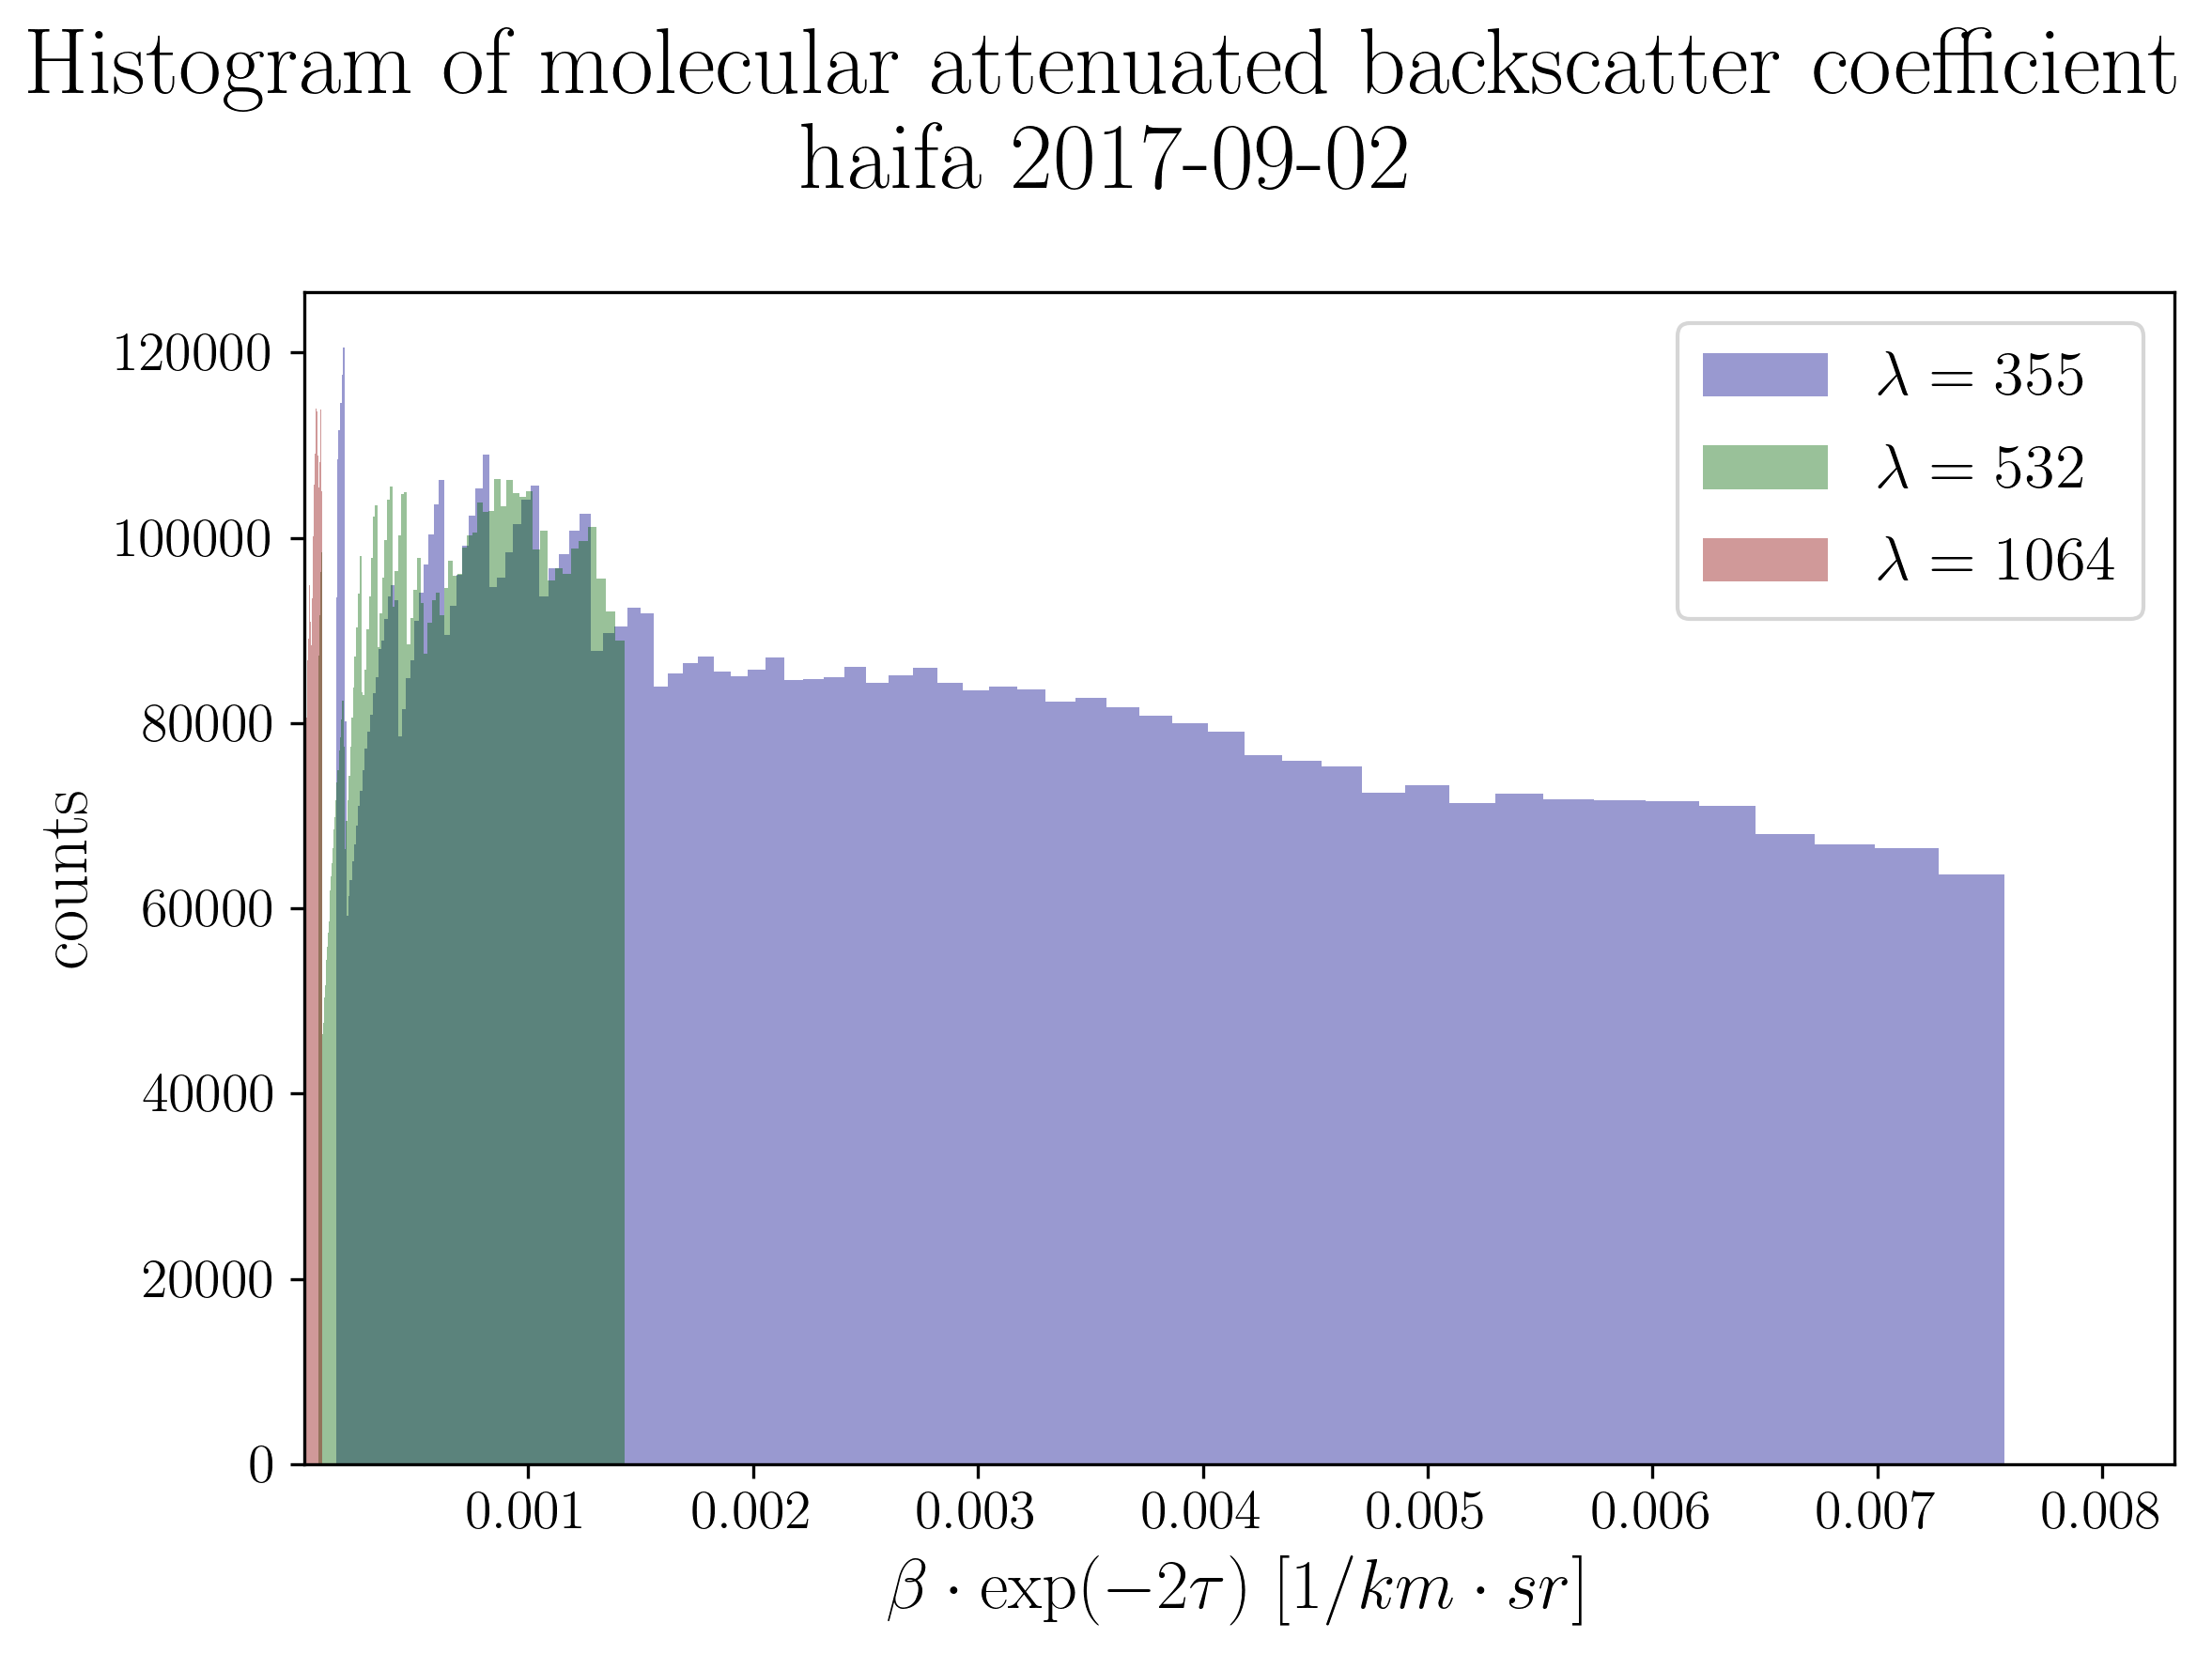

wavelength [nm]  valid size %  positive %  negative %  zeros %  \
0             355         100.0       100.0         0.0      0.0   
1             532         100.0       100.0         0.0      0.0   
2            1064         100.0       100.0         0.0      0.0   

                    mean                     std  
0   0.001733253226698244   0.0018021836935797576  
1  0.0004880363714581908   0.0003714567467678469  
2    3.2546479546333e-05  2.2943420379025305e-05

In [15]:
mol_folder = prep.get_month_folder_name(station.molecular_dataset,dt_day)
mol_nc_name = os.path.join(mol_folder, prep.get_prep_dataset_file_name(station,dt_day,data_source='molecular',lambda_nm='all'))
mol_ds = prep.load_dataset(mol_nc_name)
custom_plot_xr(mol_ds.attbsc,height_slice=slice(0,15), figsize=(16,6))
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc',nbins=100)#,log_scale=True)
mol_stats

# Statistics for a period of the dataset
# TODO: Add the section below to dataseting.py

In [80]:
start_date = datetime(2017, 9, 1)
end_date = datetime(2017, 10, 31)
data_folder = os.path.join(os.path.dirname(os.path.abspath(os.curdir)), 'data')
csv_gen_fname = f"dataset_gen_{station_name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
csv_gen_path = os.path.join(data_folder,csv_gen_fname)
df = pd.read_csv(csv_gen_path)
df['date']= pd.to_datetime(df['date'])
df['start_time_period']= pd.to_datetime(df['start_time_period'])
df['end_time_period']= pd.to_datetime(df['end_time_period'])
days_groups = df.groupby('date').groups
days_list = list(days_groups.keys())
#inds_subsets = [days_groups[key] for key in days_list]
#df_subsets = [df.iloc[inds] for inds in inds_subsets]

In [ ]:
columns = ['wavelength [nm]',
    'p_mean','p_std',
    'range_corr_mean','range_corr_std',
    'p_bg_mean','p_bg_std',
    'attbsc_mol_mean','attbsc_mol_std',
    'LC_mean','LC_std']
df_stats = pd.DataFrame(columns=columns)
df_stats['wavelength [nm]']=wavelengths
df_stats[columns[1:]]=0.0
norm_scale = 1/len(days_list)
norm_scale
# %%

for day in tqdm(days_list):
    cur_date = datetime.combine(day.date(),day.time())
    #print(cur_date)

    # %%Load datasets
    mol_folder = prep.get_month_folder_name(station.molecular_dataset,cur_date)
    mol_nc_name = os.path.join(mol_folder, prep.get_prep_dataset_file_name(station,cur_date,data_source='molecular',lambda_nm='all'))
    mol_ds = prep.load_dataset(mol_nc_name)
    p_bg = get_daily_bg(station, cur_date)  # daily background: p_bg
    signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,cur_date)
    signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,cur_date)
    signal_nc_name = os.path.join(signal_folder, gen_utils.get_gen_dataset_file_name(station,cur_date,data_source='signal'))
    signal_ds = prep.load_dataset(signal_nc_name)

    # %% update stats
    df_stats['p_mean'] += norm_scale * signal_ds.p.mean(dim ={'Height','Time'}).values
    df_stats['p_std'] += norm_scale * signal_ds.p.std(dim ={'Height','Time'}).values
    df_stats['range_corr_mean'] += norm_scale * signal_ds.range_corr.mean(dim ={'Height','Time'}).values
    df_stats['range_corr_std'] += norm_scale * signal_ds.range_corr.std(dim ={'Height','Time'}).values
    df_stats['p_bg_mean'] += norm_scale * p_bg.mean(dim ={'Time'}).values
    df_stats['p_bg_std'] += norm_scale * p_bg.std(dim ={'Time'}).values
    df_stats['attbsc_mol_mean'] += norm_scale * mol_ds.attbsc.mean(dim ={'Height','Time'}).values
    df_stats['attbsc_mol_std'] += norm_scale * mol_ds.attbsc.std(dim ={'Height','Time'}).values
    df_stats['LC_mean'] += norm_scale * signal_ds.LC.mean(dim ={'Time'}).values
    df_stats['LC_mean'] += norm_scale * signal_ds.LC.mean(dim ={'Time'}).values
    df_stats['LC_std'] += norm_scale * signal_ds.LC.std(dim ={'Time'}).values


# %% Save stats
stats_fname = f"stats_gen_{station_name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
csv_stats_path = os.path.join(data_folder,stats_fname)
df_stats.to_csv(csv_stats_path,index=False)
df_stats

 98%|█████████▊| 60/61 [11:38<00:12, 12.47s/it]